# Data Processing script for the NSM/SWEML v2.0
This .ipynb script uses python module for retrieving NASA ASO observations, locating nearest SNOTEL sites, connecting SNOTEL obs with ASO obs, and add geospatial features to the ML training/testing/hindcast dataframes.

In [1]:
import os
import model_Domain
HOME = os.path.expanduser('~')

#make SWEMLv2.0 modeling domain for western USA
region_list = model_Domain.modeldomain()
region_list.remove('NorthernRockies') # There is no ASO data for this region
region_list = ['Northwest', 'SouthernRockies', 'Southwest']
region_list

Checking for required files
ground_measures_metadata.parquet is local


['Northwest', 'SouthernRockies', 'Southwest']

In [ ]:
from ASOget import ASODownload, ASODataProcessing

# import earthaccess https://earthaccess.readthedocs.io/en/latest/howto/authenticate/
# earthaccess.login(persist=True)

# Inputs for fetching ASO data for a region
short_name = 'ASO_50M_SWE'
version = '1'
time_start = '2013-04-02T00:00:00Z'
time_end = '2019-07-19T23:59:59Z'
output_res = 300 #desired spatial resoultion in meters (m)
directory = "Raw_ASO_Data"

#Get ASO data
for region in region_list:
    print(region)
    folder_name = f"{region}/{directory}"
    data_tool = ASODownload(short_name, version)
    b_box = data_tool.BoundingBox(region)  
    url_list = data_tool.cmr_search(time_start, time_end, region, b_box)
    data_tool.cmr_download(directory, region)

    #Convert ASO tifs to parquet
    data_processor = ASODataProcessing()
    data_processor.convert_tiff_to_parquet_multiprocess(folder_name, output_res, region) 

## Get Snotel and CDEC in situ observations
- clean in situ observations, specifically the CDEC sites, need a data processing method to remove outtliers and nan/0 obs
- Ideas - add nearest sites elevation, distance from cell, then can bypass sites with bad data. 

In [ ]:
# Get in situ observations
import get_InSitu_obs
import numpy as np

#make a list of dates to aligns with the ASO observations (they go as early as Jan-29 and as far out as the July-17)
years = np.arange(2013,2020,1)
start_month_day = '10-01'
end_month_day = '08-31'
#datelist = get_InSitu_obs.make_dates(years, start_month_day, end_month_day, WY = True)

# observations 
get_InSitu_obs.Get_Monitoring_Data_Threaded_dp(years, start_month_day, end_month_day, WY = True)

#combine years
get_InSitu_obs.combine_dfs(years)

# Code for generating ML dataframe using nearest in situ monitoring sites

In [ ]:
import GeoDF
output_res = 300

region_list = ['Southwest']

# GeoDF used to create a dataframe for ML model development. Its function is to connect in situ observations to gridded locations
for region in region_list:
    path = f"{HOME}/SWEMLv2.0/data/ASO/{region}/{output_res}M_SWE_parquet"
    if os.path.isdir(path) == True:
        print(region)
        #load snotel meta location data, use haversive function
        #GeoDF.fetch_snotel_sites_for_cellids(region, output_res) # Using known up to date sites

        # Get geophysical attributes for each site, need to see how to add output resolution
        gdf = GeoDF.GeoSpatial(region, output_res)

        #use geodataframe with lat/long meta of all sites to determine slope, aspect, and elevation
        metadf = GeoDF.extract_terrain_data_threaded(gdf, region, output_res)
    else:
        print(f"No ASO data for {region}")




Southwest
Loading geospatial data for Southwest
Converting to geodataframe
Calculating dataframe bounding box
-121 35 -117 40
Retrieving Copernicus 90m DEM tiles


  0%|          | 0/30 [00:00<?, ?it/s]

There are 30 tiles in the region
Determining Grid Cell Spatial Features


  0%|          | 0/299557 [00:00<?, ?it/s]

Southwest_300M_38.163_-119.389 does not have copernicus DEM data, manual input


In [2]:
import pandas as pd

HOME = os.path.expanduser('~')
region = 'Southwest'
output_res = '300'

dfpath = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/{output_res}M_Resolution"

SWmeta = pd.read_parquet(f"{dfpath}/{region}_metadata.parquet")

In [48]:
import importlib
importlib.reload(UpdateDataFrame)

<module 'UpdateDataFrame' from '/home/whitelightning450/SWEMLv2.0/Dataprocessing/UpdateDataFrame.py'>

In [59]:
import UpdateDataFrame

#need to update the topographic features for every dataframe
output_res = '300'
training_cats = ['Obsdf']
fSCA = '' #'20_fSCA_Thresh'


for training_cat in training_cats:
    print(training_cat)

    for region in region_list:
        print(region)
        dfpath = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/{output_res}M_Resolution"
        #file to be used to updated training DF
        updatefile = pd.read_parquet(f"{dfpath}/{region}_metadata.parquet")


        #Update Dataframe
        UpdateDataFrame.updateTrainingDF(region, output_res, training_cat, fSCA, updatefile)

Obsdf
Northwest


  0%|          | 0/2 [00:00<?, ?it/s]

/home/whitelightning450/SWEMLv2.0/data/TrainingDFs/Northwest/300M_Resolution/Obsdf//                                     Date     swe_m   ns_1   ns_2  ns_3  \
cell_id                                                                   
Northwest_300M_48.09_-123.57   2016-03-29  0.000000  111.8  157.2  88.1   
Northwest_300M_48.09_-123.568  2016-03-29  0.000951  111.8  157.2  88.1   
Northwest_300M_48.09_-123.565  2016-03-29  0.000589  111.8  157.2  88.1   
Northwest_300M_48.09_-123.562  2016-03-29  0.000000  111.8  157.2  88.1   
Northwest_300M_48.09_-123.56   2016-03-29  0.000000  111.8  157.2  88.1   
...                                   ...       ...    ...    ...   ...   
Northwest_300M_47.496_-123.892 2016-03-29  0.000000  157.2  111.8  88.1   
Northwest_300M_47.496_-123.889 2016-03-29  0.000000  157.2  111.8  88.1   
Northwest_300M_47.496_-123.886 2016-03-29  0.000000  157.2  111.8  88.1   
Northwest_300M_47.496_-123.884 2016-03-29  0.000000  157.2  111.8  88.1   
Northwest_300M_4

  0%|          | 0/14 [00:00<?, ?it/s]

/home/whitelightning450/SWEMLv2.0/data/TrainingDFs/SouthernRockies/300M_Resolution/Obsdf//                                           Date  swe_m  ns_1  ns_2  ns_3  \
cell_id                                                                    
SouthernRockies_300M_37.981_-107.569 2016-04-03    0.0  50.8  37.1  50.3   
SouthernRockies_300M_37.981_-107.567 2016-04-03    0.0  50.8  37.1  50.3   
SouthernRockies_300M_37.981_-107.564 2016-04-03    0.0  50.8  37.1  50.3   
SouthernRockies_300M_37.981_-107.561 2016-04-03    0.0  50.8  37.1  50.3   
SouthernRockies_300M_37.981_-107.559 2016-04-03    0.0  50.8  37.1  50.3   
...                                         ...    ...   ...   ...   ...   
SouthernRockies_300M_37.392_-106.471 2016-04-03    0.0  24.4  36.1  66.5   
SouthernRockies_300M_37.392_-106.468 2016-04-03    0.0  24.4  36.1  66.5   
SouthernRockies_300M_37.392_-106.465 2016-04-03    0.0  24.4  36.1  66.5   
SouthernRockies_300M_37.392_-106.462 2016-04-03    0.0  24.4  36.1  66.5  

  0%|          | 0/99 [00:00<?, ?it/s]

/home/whitelightning450/SWEMLv2.0/data/TrainingDFs/Southwest/300M_Resolution/Obsdf//                                     Date  swe_m  ns_1  ns_2  ns_3  ns_4  \
cell_id                                                                    
Southwest_300M_38.193_-119.804 2014-04-07    0.0  57.0  69.9  73.7  58.0   
Southwest_300M_38.193_-119.802 2014-04-07    0.0  57.0  69.9  73.7  58.0   
Southwest_300M_38.193_-119.799 2014-04-07    0.0  57.0  69.9  73.7  58.0   
Southwest_300M_38.193_-119.796 2014-04-07    0.0  57.0  69.9  73.7  58.0   
Southwest_300M_38.193_-119.794 2014-04-07    0.0  57.0  69.9  73.7  58.0   
...                                   ...    ...   ...   ...   ...   ...   
Southwest_300M_37.729_-119.2   2014-04-07    0.0  33.7  24.9   8.1  40.1   
Southwest_300M_37.729_-119.197 2014-04-07    0.0  33.7  24.9   8.1  40.8   
Southwest_300M_37.729_-119.194 2014-04-07    0.0  33.7  24.9   8.1  40.8   
Southwest_300M_37.729_-119.192 2014-04-07    0.0  33.7  24.9   8.1  40.8   
Sout

In [52]:
trainfile = pd.read_parquet(f"{dfpath}/{training_cat}/{fSCA}/Sturm_Season_Precip_VIIRS_GeoObsDF_20150406.parquet")


In [53]:
import matplotlib.pyplot as plt
import geopandas as gpd

from mpl_toolkits.axes_grid1 import make_axes_locatable

def SpatialAnalysis(EvalDF):
    #Convert to a geopandas DF
    Pred_Geo = gpd.GeoDataFrame(EvalDF, geometry = gpd.points_from_xy(EvalDF.cen_lon, EvalDF.cen_lat))

    Pred_Geo.plot(column='Elevation_m',
                  legend=False,
                )
    
SpatialAnalysis(trainfile)

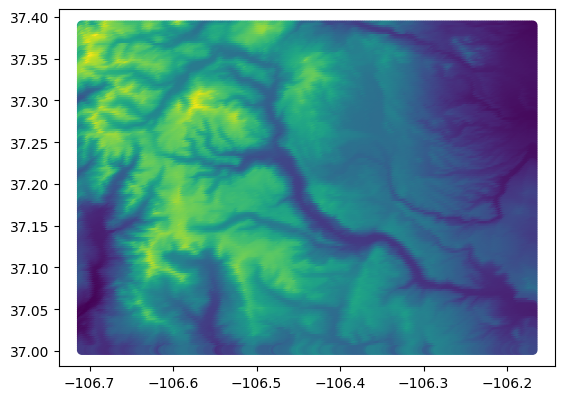

In [54]:
SpatialAnalysis(trainfile)

## Connect Snotel to each ASO obs


In [ ]:
import Obs_to_DF
output_res = 300

#Connect nearest snotel observations with ASO data, makes a parquet file for each date  -  test to see if this works - need to just load the SNOTEL file, not collect them as in the function
for region in region_list:
    path = f"{HOME}/SWEMLv2.0/data/ASO/{region}/{output_res}M_SWE_parquet"
    if os.path.isdir(path) == True:
        print(region)
        dates = []
        manual = False
        Obs_to_DF.Nearest_Snotel_2_obs_MultiProcess(region, output_res, manual, dates) 
    else:
        print(f"No ASO data for {region}")


In [ ]:
import GeoDF

output_res = 300

#Connect cell ids with ASO obs and snotel obs to geospatial features
for region in region_list:
    path = f"{HOME}/SWEMLv2.0/data/ASO/{region}/{output_res}M_SWE_parquet"
    if os.path.isdir(path) == True:
        print(region)
        GeoDF.add_geospatial_threaded(region, output_res)
    else:
        print(f"No ASO data for {region}")

# Get NASA VIIRS fraction snow covered area for each location 

* Make sure the code grabs all dates for each region


In [ ]:
import get_VIIRS_SCA
output_res = 300
threshold = 20

#check to see if the VIIRS data is available locally, if not, get from CIROH AWS - I think all of this data is for the incorrect year...
#get_VIIRS_SCA.get_VIIRS_from_AWS()

#Connect VIIRS data to dataframes
for region in region_list:
    path = f"{HOME}/SWEMLv2.0/data/ASO/{region}/{output_res}M_SWE_parquet"
    if os.path.isdir(path) == True:
        print(region)
        get_VIIRS_SCA.augment_SCA_mutliprocessing(region, output_res, threshold)
    else:
        print(f"No ASO data for {region}")


In [ ]:
import get_Precip

'''
note*, if using python > 3.9, you will likely need to change the ee package to from io import StringIO
'''

import os
HOME = os.path.expanduser('~')

#gets precipitation for each location, accumulates it through the water year

#set start/end date for a water year
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
output_res = 300
threshold = 20

for region in region_list:
    path = f"{HOME}/SWEMLv2.0/data/ASO/{region}/{output_res}M_SWE_parquet"
    if os.path.isdir(path) == True:
        print(region)
        get_Precip.get_precip_threaded(region, output_res, years)
    else:
        print(f"No ASO data for {region}")

    #Connect precipitation to processed DFs
    get_Precip.Make_Precip_DF(region, output_res, threshold)


In [ ]:
import get_Seasonality

output_res = 300
threshold = 20
for region in region_list:
    #process snotel sites to make "snow hydrograph features" to determine above/below average WY conditions
    get_Seasonality.seasonal_snotel()


    #get the Day of season metric for each dataframe
    get_Seasonality.add_Seasonality(region, output_res, threshold)

In [62]:
import sturm_processer as stpro

# output_res = 300
# threshold = 20
# for region in region_list:
#     get_Sturm.add_Sturm(region, output_res, threshold)


for region in region_list:
    input_directory = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/300M_Resolution/Seasonality_PrecipVIIRSGeoObsDFs/20_fSCA_Thresh"
    sturm_file = f"{HOME}/SWEMLv2.0/data/SnowClassification/SnowClass_NA_300m_10.0arcsec_2021_v01.0.tif" #https://nsidc.org/data/nsidc-0768/versions/1
    output_directory = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/300M_Resolution/Sturm_Seasonality_PrecipVIIRSGeoObsDFs/20_fSCA_Thresh"
    
    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    stpro.process_sturm_data_for_files(input_directory, sturm_file, output_directory)

Sturm file bounds: BoundingBox(left=-180.0, bottom=0.0, right=-10.0, top=90.0)


Processing Parquet Files:  50%|█████     | 1/2 [00:04<00:04,  4.65s/it]

                              cell_id       Date  cen_lat  cen_lon  \
79625  Northwest_300M_47.536_-123.525 2016-03-29   47.536 -123.525   
6863   Northwest_300M_48.041_-123.832 2016-03-29   48.041 -123.832   
57788  Northwest_300M_47.687_-123.967 2016-03-29   47.687 -123.967   
48990  Northwest_300M_47.749_-123.627 2016-03-29   47.749 -123.627   
84441   Northwest_300M_47.501_-124.07 2016-03-29   47.501 -124.070   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
79625         1188         44         320  0.043129  157.2   88.1  ...   
6863            43         16         225  0.000205  111.8  157.2  ...   
57788          922         25         324  0.000000  157.2  111.8  ...   
48990          735         49         106  1.842366  157.2  111.8  ...   
84441          557         27          37  0.000000  157.2  111.8  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
79625        1.712245       30.708163           1.35267

Processing Parquet Files: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]


                              cell_id       Date  cen_lat  cen_lon  \
58369  Northwest_300M_47.685_-123.446 2016-02-08   47.685 -123.446   
2922   Northwest_300M_48.068_-123.916 2016-02-08   48.068 -123.916   
53207   Northwest_300M_47.72_-123.765 2016-02-08   47.720 -123.765   
81612  Northwest_300M_47.523_-123.371 2016-02-08   47.523 -123.371   
77825   Northwest_300M_47.55_-123.174 2016-02-08   47.550 -123.174   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
58369         1331         38         245  0.123879  93.0  72.9  ...   
2922           329         12         258  0.000000  72.9  93.0  ...   
53207          940         41         206  0.000000  93.0  72.9  ...   
81612          743         53         147  0.000000  93.0  56.1  ...   
77825          399          2         180  0.000691  56.1  93.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
58369       44.640816        2.895918           1.160310           

Processing Parquet Files:   7%|▋         | 1/14 [00:01<00:16,  1.24s/it]

                                    cell_id       Date  cen_lat  cen_lon  \
1040   SouthernRockies_300M_39.091_-106.804 2019-04-07   39.091 -106.804   
8801   SouthernRockies_300M_38.983_-107.201 2019-04-07   38.983 -107.201   
29489    SouthernRockies_300M_38.7_-107.214 2019-04-07   38.700 -107.214   
2142   SouthernRockies_300M_39.075_-107.036 2019-04-07   39.075 -107.036   
12372  SouthernRockies_300M_38.935_-107.144 2019-04-07   38.935 -107.144   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
1040          2792         17         213  0.198246  50.3  53.6  ...   
8801          2893         50         226  0.000000  52.6  48.5  ...   
29489         3362         42         263  0.887973  48.5  52.6  ...   
2142          3234          9         254  0.932080  52.6  48.5  ...   
12372         3598         55         250  0.834239  52.6  48.5  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
1040        15.122449       37.

Processing Parquet Files:  14%|█▍        | 2/14 [00:02<00:11,  1.03it/s]

                                    cell_id       Date  cen_lat  cen_lon  \
21995  SouthernRockies_300M_38.702_-106.969 2018-05-24   38.702 -106.969   
12537  SouthernRockies_300M_38.862_-107.222 2018-05-24   38.862 -107.222   
3613   SouthernRockies_300M_39.002_-107.028 2018-05-24   39.002 -107.028   
51     SouthernRockies_300M_39.099_-107.193 2018-05-24   39.099 -107.193   
11261  SouthernRockies_300M_38.883_-106.882 2018-05-24   38.883 -106.882   

       Elevation_m  Slope_Deg  Aspect_Deg    swe_m  ns_1  ns_2  ...  \
21995         3798         39         270  0.00000   0.0   0.0  ...   
12537         3461         35         167  0.00000   0.0   0.0  ...   
3613          3204         10         119  0.00427   0.0   0.0  ...   
51            3421          7         138  0.00000   0.0   0.0  ...   
11261         3757         46          39  0.00000   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
21995       16.648980        4.808163

Processing Parquet Files:  21%|██▏       | 3/14 [00:02<00:09,  1.18it/s]

                                    cell_id       Date  cen_lat  cen_lon  \
12349    SouthernRockies_300M_39.37_-106.15 2019-06-24   39.370 -106.150   
4769   SouthernRockies_300M_39.548_-105.956 2019-06-24   39.548 -105.956   
2070   SouthernRockies_300M_39.599_-105.818 2019-06-24   39.599 -105.818   
540    SouthernRockies_300M_39.634_-105.805 2019-06-24   39.634 -105.805   
6439   SouthernRockies_300M_39.518_-105.961 2019-06-24   39.518 -105.961   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
12349         2548          0           0  0.037812  36.3  11.7  ...   
4769          2901         24         234  0.022494   0.0   1.0  ...   
2070          2617         14         134  0.210091   0.0   1.0  ...   
540           2623         17          32  0.263944   1.0   0.0  ...   
6439          2774         32          11  0.000021   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
12349        0.016327        0.

Processing Parquet Files:  29%|██▊       | 4/14 [00:03<00:07,  1.31it/s]

                                   cell_id       Date  cen_lat  cen_lon  \
7027  SouthernRockies_300M_38.831_-106.438 2018-03-30   38.831 -106.438   
7918  SouthernRockies_300M_38.796_-106.478 2018-03-30   38.796 -106.478   
7060  SouthernRockies_300M_38.828_-106.584 2018-03-30   38.828 -106.584   
2367   SouthernRockies_300M_38.95_-106.694 2018-03-30   38.950 -106.694   
8895  SouthernRockies_300M_38.731_-106.422 2018-03-30   38.731 -106.422   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
7027         3942         59          58  0.188461  19.0  18.5  ...   
7918         3551         28          67  0.070348  19.0  18.5  ...   
7060         3760         11          87  0.000000  19.0  27.2  ...   
2367         3467         66          52  0.247326  27.2  26.2  ...   
8895         3497         27         132  0.140861  18.5  19.0  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
7027       13.595918       35.061224        

Processing Parquet Files:  36%|███▌      | 5/14 [00:03<00:06,  1.46it/s]

                                   cell_id       Date  cen_lat  cen_lon  \
1607  SouthernRockies_300M_38.932_-106.946 2016-04-04   38.932 -106.946   
1991   SouthernRockies_300M_38.91_-106.962 2016-04-04   38.910 -106.962   
908   SouthernRockies_300M_38.969_-107.019 2016-04-04   38.969 -107.019   
1561   SouthernRockies_300M_38.934_-106.93 2016-04-04   38.934 -106.930   
404   SouthernRockies_300M_38.999_-106.921 2016-04-04   38.999 -106.921   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
1607         3433         27         100  0.206878  33.5  33.5  ...   
1991         3804         80         129  0.177086  33.5  33.5  ...   
908          3048         20          75  0.519528  33.5  33.0  ...   
1561         3539         56          63  0.254803  33.5  33.5  ...   
404          3806         40         298  0.600961  33.5  33.5  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
1607       27.340816       34.397959        

Processing Parquet Files:  43%|████▎     | 6/14 [00:04<00:05,  1.37it/s]

                                    cell_id       Date  cen_lat  cen_lon  \
1677   SouthernRockies_300M_39.051_-107.225 2018-03-31   39.051 -107.225   
22482  SouthernRockies_300M_38.692_-106.928 2018-03-31   38.692 -106.928   
3510   SouthernRockies_300M_39.005_-106.969 2018-03-31   39.005 -106.969   
2397   SouthernRockies_300M_39.032_-107.055 2018-03-31   39.032 -107.055   
17334  SouthernRockies_300M_38.786_-106.812 2018-03-31   38.786 -106.812   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
1677          2977         14          36  0.000000  29.2  22.6  ...   
22482         3566         57          63  0.000000  22.6  19.0  ...   
3510          2869          9          13  0.490564  22.6  29.2  ...   
2397          3491          9         180  0.377909  29.2  22.6  ...   
17334         3352         63         121  0.209095  22.6  19.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
1677        57.502041       34.

Processing Parquet Files:  50%|█████     | 7/14 [00:05<00:05,  1.23it/s]

                                   cell_id       Date  cen_lat  cen_lon  \
5868   SouthernRockies_300M_39.529_-105.88 2019-04-19   39.529 -105.880   
4860  SouthernRockies_300M_39.545_-106.086 2019-04-19   39.545 -106.086   
9233  SouthernRockies_300M_39.462_-106.196 2019-04-19   39.462 -106.196   
3273  SouthernRockies_300M_39.575_-106.204 2019-04-19   39.575 -106.204   
9126  SouthernRockies_300M_39.464_-106.142 2019-04-19   39.464 -106.142   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
5868         2607          9         122  0.771853  42.9  36.6  ...   
4860         2560         26         310  0.218235  51.3  36.6  ...   
9233         2386          1         297  0.879098  51.3  60.5  ...   
3273         2379          0           0  0.717835  51.3  51.8  ...   
9126         2531         10         191  0.241008  51.3  60.5  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
5868       42.946939       20.424490        

Processing Parquet Files:  57%|█████▋    | 8/14 [00:06<00:04,  1.29it/s]

                                   cell_id       Date  cen_lat  cen_lon  \
5925  SouthernRockies_300M_38.861_-106.489 2019-06-09   38.861 -106.489   
7873  SouthernRockies_300M_38.799_-106.462 2019-06-09   38.799 -106.462   
4932  SouthernRockies_300M_38.885_-106.365 2019-06-09   38.885 -106.365   
3721  SouthernRockies_300M_38.909_-106.522 2019-06-09   38.909 -106.522   
8065  SouthernRockies_300M_38.788_-106.457 2019-06-09   38.788 -106.457   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
5925         3721         33          64  0.000000   0.0   0.3  ...   
7873         3550         35         129  0.000130   0.0   0.3  ...   
4932         2928         26         100  0.541212   0.3   0.0  ...   
3721         3717         46         183  0.000000   0.0   6.9  ...   
8065         3675         35          29  0.022338   0.0   0.3  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
5925        1.136735        1.271429        

Processing Parquet Files:  64%|██████▍   | 9/14 [00:07<00:04,  1.12it/s]

                                    cell_id       Date  cen_lat  cen_lon  \
8375   SouthernRockies_300M_37.811_-107.421 2016-04-03   37.811 -107.421   
3370   SouthernRockies_300M_37.884_-106.646 2016-04-03   37.884 -106.646   
26317  SouthernRockies_300M_37.565_-107.567 2016-04-03   37.565 -107.567   
27932   SouthernRockies_300M_37.395_-106.56 2016-04-03   37.395 -106.560   
8656   SouthernRockies_300M_37.808_-107.337 2016-04-03   37.808 -107.337   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
8375          3821         55         323  0.515573  50.3  17.3  ...   
3370          3035         12          19  0.500515  20.3  36.1  ...   
26317         3712         27          52  0.000000  38.6  50.3  ...   
27932         3052         11         289  0.000000  24.4  36.1  ...   
8656          3182         36         201  0.052670  17.3  50.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
8375        32.861224       42.

Processing Parquet Files:  71%|███████▏  | 10/14 [00:08<00:03,  1.19it/s]

                                    cell_id       Date  cen_lat  cen_lon  \
10682  SouthernRockies_300M_38.773_-106.952 2019-06-10   38.773 -106.952   
12655  SouthernRockies_300M_38.735_-107.179 2019-06-10   38.735 -107.179   
10527  SouthernRockies_300M_38.775_-106.993 2019-06-10   38.775 -106.993   
10367  SouthernRockies_300M_38.778_-107.039 2019-06-10   38.778 -107.039   
13743  SouthernRockies_300M_38.716_-106.993 2019-06-10   38.716 -106.993   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
10682         3603         45         111  0.141574   0.0   8.6  ...   
12655         2950         48          29  1.349540   0.0   0.0  ...   
10527         3300         18          10  0.000000   0.0   8.6  ...   
10367         3530         70         261  0.000002   0.0   8.6  ...   
13743         3300         18          10  0.000000   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
10682        0.077551        0.

Processing Parquet Files:  79%|███████▊  | 11/14 [00:09<00:02,  1.08it/s]

                                    cell_id       Date  cen_lat  cen_lon  \
44034  SouthernRockies_300M_37.538_-106.819 2015-04-07   37.538 -106.819   
2245    SouthernRockies_300M_37.911_-106.94 2015-04-07   37.911 -106.940   
14682    SouthernRockies_300M_37.8_-106.614 2015-04-07   37.800 -106.614   
16601  SouthernRockies_300M_37.787_-106.835 2015-04-07   37.787 -106.835   
19344  SouthernRockies_300M_37.768_-107.013 2015-04-07   37.768 -107.013   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
44034         3358         42         327  0.017009  33.5  41.7  ...   
2245          3614         23         263  0.000355  30.0   4.1  ...   
14682         3263         15         207  0.000000   4.1  17.5  ...   
16601         3537         32         212  0.000000   4.1  33.5  ...   
19344         3545         25         304  0.000000   0.0  30.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
44034        8.687755       36.

Processing Parquet Files:  86%|████████▌ | 12/14 [00:10<00:01,  1.18it/s]

                                   cell_id       Date  cen_lat  cen_lon  \
9228  SouthernRockies_300M_38.704_-106.462 2019-04-08   38.704 -106.462   
5589  SouthernRockies_300M_38.869_-106.524 2019-04-08   38.869 -106.524   
1963  SouthernRockies_300M_38.963_-106.646 2019-04-08   38.963 -106.646   
8293  SouthernRockies_300M_38.772_-106.508 2019-04-08   38.772 -106.508   
9266  SouthernRockies_300M_38.699_-106.503 2019-04-08   38.699 -106.503   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
9228         3550         35         129  0.619741  37.8  37.3  ...   
5589         3841         45         207  0.133692  37.3  37.8  ...   
1963         3443         26          25  0.193615  50.0  53.6  ...   
8293         3920         59         346  0.325680  37.3  37.8  ...   
9266         3837         26         139  0.405780  37.8  37.3  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
9228       27.371429       35.138776        

Processing Parquet Files:  93%|█████████▎| 13/14 [00:10<00:00,  1.16it/s]

                                    cell_id       Date  cen_lat  cen_lon  \
18699  SouthernRockies_300M_37.139_-106.693 2015-04-06   37.139 -106.693   
18606  SouthernRockies_300M_37.141_-106.402 2015-04-06   37.141 -106.402   
13050  SouthernRockies_300M_37.217_-106.207 2015-04-06   37.217 -106.207   
6646   SouthernRockies_300M_37.301_-106.674 2015-04-06   37.301 -106.674   
3073   SouthernRockies_300M_37.349_-106.553 2015-04-06   37.349 -106.553   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
18699         3098         12         288  0.000000  46.2  16.5  ...   
18606         3078         12         185  0.000033  46.2  16.5  ...   
13050         2565         19         201  0.000000  46.2  16.5  ...   
6646          3000         29         280  0.524626  16.5  18.5  ...   
3073          3001         18         236  0.035725  16.5  18.5  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
18699       62.859184        8.

Processing Parquet Files: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


                                    cell_id       Date  cen_lat  cen_lon  \
111    SouthernRockies_300M_37.957_-107.002 2015-06-02   37.957 -107.002   
3722   SouthernRockies_300M_37.889_-107.159 2015-06-02   37.889 -107.159   
37144  SouthernRockies_300M_37.635_-106.662 2015-06-02   37.635 -106.662   
28652  SouthernRockies_300M_37.703_-107.102 2015-06-02   37.703 -107.102   
29249    SouthernRockies_300M_37.7_-106.506 2015-06-02   37.700 -106.506   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
111           3862         53         257  0.287580   5.3   0.0  ...   
3722          3162         39         350  0.000000   5.3   0.0  ...   
37144         3000          4         207  0.000000  36.1   0.0  ...   
28652         3406         31         214  0.000056   0.0   0.0  ...   
29249         3124         15         356  0.000000   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
111         10.434694       31.

Processing Parquet Files:   1%|          | 1/99 [00:00<01:37,  1.01it/s]

                              cell_id       Date  cen_lat  cen_lon  \
6005     Southwest_300M_37.57_-119.04 2018-04-22   37.570 -119.040   
6582   Southwest_300M_37.559_-119.119 2018-04-22   37.559 -119.119   
16753  Southwest_300M_37.367_-119.178 2018-04-22   37.367 -119.178   
17553  Southwest_300M_37.343_-119.321 2018-04-22   37.343 -119.321   
282    Southwest_300M_37.715_-119.256 2018-04-22   37.715 -119.256   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
6005          1975          4         291  0.436138    68.0 -9999.0  ...   
6582          1945          0           0  0.000000 -9999.0    68.0  ...   
16753         2817         66         247  0.000000     0.6     9.4  ...   
17553         3197         66         302  0.000000     0.6     9.4  ...   
282           3211         43         145  1.848826    64.8    42.2  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
6005     -1375.777551      282.142857      

Processing Parquet Files:   2%|▏         | 2/99 [00:02<01:54,  1.18s/it]

                              cell_id       Date  cen_lat  cen_lon  \
36803  Southwest_300M_37.761_-119.364 2014-05-02   37.761 -119.364   
38627  Southwest_300M_37.739_-119.386 2014-05-02   37.739 -119.386   
610    Southwest_300M_38.188_-119.394 2014-05-02   38.188 -119.394   
5009   Southwest_300M_38.136_-119.264 2014-05-02   38.136 -119.264   
10819  Southwest_300M_38.066_-119.653 2014-05-02   38.066 -119.653   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
36803         2841          9          61  0.000000  17.5  16.8  ...   
38627         2591         17          97  0.000000  17.5  16.8  ...   
610           1547          7          82  0.000000  12.2   0.0  ...   
5009          1683         25         284  0.000000  12.2  23.6  ...   
10819         1573          2          63  0.018856  26.5  43.9  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
36803       29.032653    -2824.265306          -0.012473           

Processing Parquet Files:   3%|▎         | 3/99 [00:03<01:47,  1.12s/it]

                              cell_id       Date  cen_lat  cen_lon  \
29209   Southwest_300M_37.85_-119.464 2014-04-28   37.850 -119.464   
2680    Southwest_300M_38.163_-119.37 2014-04-28   38.163 -119.370   
26160  Southwest_300M_37.885_-119.659 2014-04-28   37.885 -119.659   
33528  Southwest_300M_37.799_-119.551 2014-04-28   37.799 -119.551   
22557  Southwest_300M_37.928_-119.494 2014-04-28   37.928 -119.494   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
29209         2984         32          94  0.000000  17.8   0.8  ...   
2680          1695         24          59  0.000000  14.2   0.0  ...   
26160         2552         16         342  0.000000   0.8   7.6  ...   
33528         2242         22          95  0.000000   0.8  17.8  ...   
22557         2949         31         225  0.009122  17.8   0.8  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
29209       67.093878    -2032.495918          -0.012687          -

Processing Parquet Files:   4%|▍         | 4/99 [00:04<01:42,  1.08s/it]

                              cell_id       Date  cen_lat  cen_lon  \
18956  Southwest_300M_37.151_-119.683 2018-04-23   37.151 -119.683   
5986   Southwest_300M_37.321_-119.316 2018-04-23   37.321 -119.316   
4639   Southwest_300M_37.356_-119.553 2018-04-23   37.356 -119.553   
6815     Southwest_300M_37.3_-119.359 2018-04-23   37.300 -119.359   
20678  Southwest_300M_37.129_-119.248 2018-04-23   37.129 -119.248   

       Elevation_m  Slope_Deg  Aspect_Deg         swe_m  ns_1  ns_2  ...  \
18956         2064          9          43  0.000000e+00  11.6   5.8  ...   
5986          3281         58          51  0.000000e+00   5.8   0.6  ...   
4639          2294         19         177  0.000000e+00  11.6   0.6  ...   
6815          2869          6         329  0.000000e+00   5.8  11.6  ...   
20678         2913         15         228  4.809732e-07   1.2   5.8  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
18956       37.208163       69.430612      

Processing Parquet Files:   5%|▌         | 5/99 [00:05<01:31,  1.02it/s]

                              cell_id       Date  cen_lat  cen_lon  \
9815   Southwest_300M_38.037_-119.544 2019-07-05   38.037 -119.544   
13140  Southwest_300M_37.997_-119.892 2019-07-05   37.997 -119.892   
20513  Southwest_300M_37.889_-119.322 2019-07-05   37.889 -119.322   
22928  Southwest_300M_37.805_-119.222 2019-07-05   37.805 -119.222   
10351   Southwest_300M_38.032_-119.33 2019-07-05   38.032 -119.330   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
9815          1889         44          62  0.961375     0.0  11.4  ...   
13140         1562         31          48  0.000000     0.0  26.5  ...   
20513         3147         52         315  0.000000     0.4   3.5  ...   
22928         3149         17         272  0.272833     3.5   3.5  ...   
10351         1490         15         101  0.000002 -9999.0   3.5  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
9815     -1632.459184     -162.373469           0.00000

Processing Parquet Files:   6%|▌         | 6/99 [00:06<01:36,  1.04s/it]

                              cell_id       Date  cen_lat  cen_lon  \
11555  Southwest_300M_36.466_-118.732 2019-03-24   36.466 -118.732   
16744  Southwest_300M_36.379_-118.773 2019-03-24   36.379 -118.773   
12649  Southwest_300M_36.447_-118.918 2019-03-24   36.447 -118.918   
5266   Southwest_300M_36.579_-118.619 2019-03-24   36.579 -118.619   
14025  Southwest_300M_36.425_-118.748 2019-03-24   36.425 -118.748   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1    ns_2  ...  \
11555         3207         38         230  0.033193   52.8   120.6  ...   
16744         2985         35          40  0.000003  120.6    52.8  ...   
12649         2752         26         333  0.000000   52.8 -9999.0  ...   
5266          2450         96          67  0.000000   52.8    87.3  ...   
14025         2828         25         110  0.000000   52.8   120.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
11555     -745.722449       38.006122          -0

Processing Parquet Files:   7%|▋         | 7/99 [00:07<01:25,  1.07it/s]

                              cell_id       Date  cen_lat  cen_lon  \
3050   Southwest_300M_38.058_-119.672 2016-05-27   38.058 -119.672   
7289   Southwest_300M_37.985_-119.729 2016-05-27   37.985 -119.729   
12986  Southwest_300M_37.899_-119.264 2016-05-27   37.899 -119.264   
7483   Southwest_300M_37.982_-119.672 2016-05-27   37.982 -119.672   
733    Southwest_300M_38.123_-119.505 2016-05-27   38.123 -119.505   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
3050          1556          4         344  0.065543  15.6    53.3  ...   
7289          2054         27         326  0.000002  15.6 -9999.0  ...   
12986         3390         49         333  0.075302  10.7 -9999.0  ...   
7483          2442         10         137  0.000000  15.6 -9999.0  ...   
733           2017         21           0  0.674900  53.3    15.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
3050       -88.287755       26.455102           0.41674

Processing Parquet Files:   8%|▊         | 8/99 [00:07<01:23,  1.09it/s]

                              cell_id       Date  cen_lat  cen_lon  \
21557  Southwest_300M_36.807_-118.736 2015-05-31   36.807 -118.736   
14607   Southwest_300M_36.92_-118.563 2015-05-31   36.920 -118.563   
2942   Southwest_300M_37.109_-118.496 2015-05-31   37.109 -118.496   
9518   Southwest_300M_37.004_-118.326 2015-05-31   37.004 -118.326   
21279  Southwest_300M_36.812_-118.585 2015-05-31   36.812 -118.585   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
21557         3131         47         317  0.000000     1.2     1.8  ...   
14607         2917         67          73  0.036381 -9999.0     1.2  ...   
2942          2320         36         122  0.000000     0.0     0.0  ...   
9518          2087         11         349  0.000000     0.0 -9999.0  ...   
21279         2105         34          13  0.000000     1.2 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
21557    -5500.500000    -1414.083673      

Processing Parquet Files:   9%|▉         | 9/99 [00:08<01:16,  1.18it/s]

                              cell_id       Date  cen_lat  cen_lon  \
12092  Southwest_300M_37.637_-119.693 2019-07-03   37.637 -119.693   
13868  Southwest_300M_37.601_-119.448 2019-07-03   37.601 -119.448   
8315   Southwest_300M_37.704_-119.488 2019-07-03   37.704 -119.488   
5417    Southwest_300M_37.75_-119.639 2019-07-03   37.750 -119.639   
653    Southwest_300M_37.853_-119.464 2019-07-03   37.853 -119.464   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
12092         2360         54         146  0.000000   0.0   0.0  ...   
13868         3138         13          18  0.089453   0.9   0.0  ...   
8315          2979          9          21  0.000000   0.4   0.0  ...   
5417          2171         68         322  0.000000   0.0   0.0  ...   
653           2984         32          94  0.000812   0.4   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
12092      328.069388        1.416327          -0.000000           

Processing Parquet Files:  10%|█         | 10/99 [00:09<01:12,  1.23it/s]

                              cell_id       Date  cen_lat  cen_lon  \
13996   Southwest_300M_37.435_-119.14 2017-08-15   37.435 -119.140   
426     Southwest_300M_37.71_-119.178 2017-08-15   37.710 -119.178   
15023     Southwest_300M_37.41_-119.1 2017-08-15   37.410 -119.100   
464    Southwest_300M_37.707_-119.238 2017-08-15   37.707 -119.238   
10582  Southwest_300M_37.497_-119.032 2017-08-15   37.497 -119.032   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
13996         1945          0           0  0.000000  1021.4     1.2  ...   
426           2817         66         247  0.011069     1.9     0.0  ...   
15023         1945          0           0  0.000000     1.9  1021.4  ...   
464           3287         58         324  0.074653     1.9     0.0  ...   
10582         2030          5         259  0.000000     0.0     2.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
13996    -3672.469388        0.312245      

Processing Parquet Files:  11%|█         | 11/99 [00:10<01:12,  1.22it/s]

                              cell_id       Date  cen_lat  cen_lon  \
10531    Southwest_300M_37.937_-119.4 2017-01-29   37.937 -119.400   
5343   Southwest_300M_38.018_-119.422 2017-01-29   38.018 -119.422   
3888   Southwest_300M_38.043_-119.595 2017-01-29   38.043 -119.595   
11960  Southwest_300M_37.913_-119.622 2017-01-29   37.913 -119.622   
11805  Southwest_300M_37.916_-119.606 2017-01-29   37.916 -119.606   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
10531         2975         31         345  0.811644   73.6   87.4  ...   
5343          1685          6         200  0.938324   73.6   54.1  ...   
3888          1711          7          63  0.591322  108.8  135.9  ...   
11960         2472         22         136  0.228039   84.7  108.8  ...   
11805         2404         42         350  0.402322   84.7  108.8  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
10531     -975.797959       27.706122           3.34390

Processing Parquet Files:  12%|█▏        | 12/99 [00:11<01:22,  1.06it/s]

                              cell_id       Date  cen_lat  cen_lon  \
527    Southwest_300M_38.131_-119.564 2013-05-03   38.131 -119.564   
2480   Southwest_300M_38.072_-119.524 2013-05-03   38.072 -119.524   
10709  Southwest_300M_37.934_-119.578 2013-05-03   37.934 -119.578   
15550  Southwest_300M_37.823_-119.246 2013-05-03   37.823 -119.246   
6168    Southwest_300M_38.004_-119.58 2013-05-03   38.004 -119.580   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
527           1839         11          56  0.682371  57.5  14.5  ...   
2480          1911          2         297  0.568195  14.5  57.5  ...   
10709         2695         30         154  0.000000   0.0  14.5  ...   
15550         2889          8           7  0.055689  31.4  11.4  ...   
6168          1910         29         327  0.105107  14.5   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
527      -1427.548980       47.785714           0.541140           

Processing Parquet Files:  13%|█▎        | 13/99 [00:12<01:16,  1.12it/s]

                              cell_id       Date  cen_lat  cen_lon  \
135    Southwest_300M_37.912_-119.359 2015-04-28   37.912 -119.359   
20250  Southwest_300M_37.601_-119.696 2015-04-28   37.601 -119.696   
17069  Southwest_300M_37.653_-119.256 2015-04-28   37.653 -119.256   
13859  Southwest_300M_37.701_-119.369 2015-04-28   37.701 -119.369   
1251   Southwest_300M_37.893_-119.672 2015-04-28   37.893 -119.672   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
135           2869          6         329  0.000000     4.3   2.3  ...   
20250         2474         54         117  0.000000     0.6   0.0  ...   
17069         3211         43         145  0.000000     0.0   1.3  ...   
13859         2813         21         349  0.000002     4.3  27.1  ...   
1251          2433         10         169  0.000000 -9999.0   0.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
135      -2824.265306    -1407.348980          -0.00306

Processing Parquet Files:  14%|█▍        | 14/99 [00:13<01:18,  1.08it/s]

                             cell_id       Date  cen_lat  cen_lon  \
7956  Southwest_300M_37.977_-119.354 2013-04-29   37.977 -119.354   
1906  Southwest_300M_38.085_-119.534 2013-04-29   38.085 -119.534   
7822  Southwest_300M_37.977_-119.715 2013-04-29   37.977 -119.715   
8912  Southwest_300M_37.961_-119.629 2013-04-29   37.961 -119.629   
4855  Southwest_300M_38.026_-119.626 2013-04-29   38.026 -119.626   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
7956         2906         10         321  0.201590   0.0  21.6  ...   
1906         1875          6          81  0.361640  28.9  71.4  ...   
7822         2388         30         283  0.000086  28.9   0.0  ...   
8912         2306         37         308  0.065993  28.9   0.0  ...   
4855         1652          7          74  0.000000  28.9  71.4  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
7956       67.093878    -2824.265306           -0.00000          -0.027981   
19

Processing Parquet Files:  15%|█▌        | 15/99 [00:14<01:24,  1.01s/it]

                              cell_id       Date  cen_lat  cen_lon  \
44414  Southwest_300M_36.716_-119.038 2019-03-16   36.716 -119.038   
17333   Southwest_300M_36.97_-119.097 2019-03-16   36.970 -119.097   
11449   Southwest_300M_37.03_-118.708 2019-03-16   37.030 -118.708   
36906  Southwest_300M_36.787_-118.957 2019-03-16   36.787 -118.957   
26959  Southwest_300M_36.881_-118.579 2019-03-16   36.881 -118.579   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1   ns_2  ...  \
44414         2163         29          73  0.000000 -9999.0  134.3  ...   
17333         1726         57          97  0.000000   117.5  118.3  ...   
11449         2163          2         180  0.000000 -9999.0  117.5  ...   
36906         2131         39          12  0.000000 -9999.0  134.3  ...   
26959         2397         54          18  1.590038     0.0  134.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
44414    -2789.683673       53.446939           7

Processing Parquet Files:  16%|█▌        | 16/99 [00:15<01:17,  1.07it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
67   Southwest_300M_37.611_-119.002 2017-07-18   37.611 -119.002         1945   
48   Southwest_300M_37.614_-119.019 2017-07-18   37.614 -119.019         1945   
103  Southwest_300M_37.606_-118.989 2017-07-18   37.606 -118.989         1945   
227  Southwest_300M_37.587_-119.013 2017-07-18   37.587 -119.013         1945   
295  Southwest_300M_37.579_-118.983 2017-07-18   37.579 -118.983         1945   

     Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  ns_5_week_mean  \
67           0           0  0.000000   0.0   0.6  ...        1.571429   
48           0           0  0.000634   0.0   0.6  ...        1.571429   
103          0           0  0.000197   0.0   0.6  ...        1.571429   
227          0           0  0.204467   0.0   0.6  ...    -2856.226531   
295          0           0  0.063889   0.0   0.6  ...    -2856.226531   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_ns_3_r

Processing Parquet Files:  17%|█▋        | 17/99 [00:15<01:11,  1.15it/s]

                              cell_id       Date  cen_lat  cen_lon  \
3233   Southwest_300M_37.788_-119.688 2019-06-04   37.788 -119.688   
10934  Southwest_300M_37.658_-119.688 2019-06-04   37.658 -119.688   
5400    Southwest_300M_37.75_-119.685 2019-06-04   37.750 -119.685   
4492   Southwest_300M_37.766_-119.577 2019-06-04   37.766 -119.577   
10844  Southwest_300M_37.661_-119.529 2019-06-04   37.661 -119.529   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
3233          2104         57         124  0.000000   0.0  43.5  ...   
10934         2104         57         124  0.000000   0.0  43.5  ...   
5400          2056         17          85  0.000000   0.0  43.5  ...   
4492          2695         30         154  0.000027  43.5   0.0  ...   
10844         2557         41         313  0.000000   0.0  43.5  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
3233     -2841.328571       47.273469          -0.000000          -

Processing Parquet Files:  18%|█▊        | 18/99 [00:16<01:06,  1.22it/s]

                              cell_id       Date  cen_lat  cen_lon  \
13352  Southwest_300M_37.116_-118.714 2019-05-02   37.116 -118.714   
11284  Southwest_300M_37.208_-118.833 2019-05-02   37.208 -118.833   
850    Southwest_300M_37.445_-118.908 2019-05-02   37.445 -118.908   
5753   Southwest_300M_37.318_-118.978 2019-05-02   37.318 -118.978   
4579    Southwest_300M_37.345_-118.87 2019-05-02   37.345 -118.870   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
13352         2153          3         162  1.627425 -9999.0    49.6  ...   
11284         2311         12         275  1.301139   117.9 -9999.0  ...   
850           1950          0           0  0.831217    98.6    19.6  ...   
5753          1945          0           0  0.000000    98.6   117.9  ...   
4579          2204         28           0  0.715708    98.6    19.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
13352       59.867347    -1382.532653      

Processing Parquet Files:  19%|█▉        | 19/99 [00:17<01:00,  1.33it/s]

                             cell_id       Date  cen_lat  cen_lon  \
3889  Southwest_300M_38.086_-119.681 2016-04-07   38.086 -119.681   
130   Southwest_300M_38.207_-119.773 2016-04-07   38.207 -119.773   
5995  Southwest_300M_38.016_-119.846 2016-04-07   38.016 -119.846   
5559  Southwest_300M_38.032_-119.886 2016-04-07   38.032 -119.886   
1941  Southwest_300M_38.145_-119.719 2016-04-07   38.145 -119.719   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
3889         1529         10          61  1.269744  101.2  111.9  ...   
130          1429          1          63  0.655570  102.1  111.9  ...   
5995         1470          6         180  0.160595  101.2  102.1  ...   
5559         2497         35         213  0.011383  101.2  102.1  ...   
1941         1466          2           0  0.739114  111.9  101.2  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
3889    -2803.744898       60.630612           1.061251           0.

Processing Parquet Files:  20%|██        | 20/99 [00:18<01:05,  1.21it/s]

                              cell_id       Date  cen_lat  cen_lon  \
16301  Southwest_300M_37.777_-119.259 2013-05-25   37.777 -119.259   
100    Southwest_300M_38.161_-119.599 2013-05-25   38.161 -119.599   
8243   Southwest_300M_37.972_-119.534 2013-05-25   37.972 -119.534   
7847   Southwest_300M_37.977_-119.648 2013-05-25   37.977 -119.648   
12078  Southwest_300M_37.912_-119.497 2013-05-25   37.912 -119.497   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
16301         3428         79         183  0.026457  11.3   2.6  ...   
100           1697          4          56  0.307720   1.0  67.1  ...   
8243          2433         61         271  0.000000   0.5   0.0  ...   
7847          2339         49         123  0.000000   0.5   0.0  ...   
12078         3019         13         171  0.020985   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
16301    -1422.363265       14.073469           0.299946          -

Processing Parquet Files:  21%|██        | 21/99 [00:18<01:02,  1.24it/s]

                              cell_id       Date  cen_lat  cen_lon  \
9833   Southwest_300M_37.947_-119.545 2013-06-01   37.947 -119.545   
16337  Southwest_300M_37.775_-119.237 2013-06-01   37.775 -119.237   
4143   Southwest_300M_38.039_-119.483 2013-06-01   38.039 -119.483   
6497   Southwest_300M_37.999_-119.594 2013-06-01   37.999 -119.594   
15142   Southwest_300M_37.839_-119.37 2013-06-01   37.839 -119.370   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
9833          2339         33         344  0.000000   0.0     0.5  ...   
16337         3287         58         324  0.113614   0.0     1.3  ...   
4143          2228         28         296  0.000040   0.5     1.3  ...   
6497          2673         23         109  0.000564   0.5     0.0  ...   
15142         2796         17         336  0.045600   0.0 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
9833     -2834.316327    -3059.202041           -0.0000

Processing Parquet Files:  22%|██▏       | 22/99 [00:19<01:02,  1.24it/s]

                              cell_id       Date  cen_lat  cen_lon  \
7186    Southwest_300M_37.989_-119.36 2016-05-09   37.989 -119.360   
11775  Southwest_300M_37.916_-119.687 2016-05-09   37.916 -119.687   
10498   Southwest_300M_37.937_-119.49 2016-05-09   37.937 -119.490   
14692  Southwest_300M_37.856_-119.314 2016-05-09   37.856 -119.314   
11651  Southwest_300M_37.918_-119.581 2016-05-09   37.918 -119.581   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
7186          2864          5         336  0.585858 -9999.0    46.7  ...   
11775         2057         44         103  0.000232 -9999.0    63.0  ...   
10498         2975         11          52  0.000007 -9999.0 -9999.0  ...   
14692         3367         52          48  0.202866 -9999.0    46.7  ...   
11651         2701          4         326  0.018308 -9999.0    63.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
7186        44.565306    -2831.187755      

Processing Parquet Files:  23%|██▎       | 23/99 [00:20<00:55,  1.38it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
120  Southwest_300M_37.603_-118.989 2016-06-14   37.603 -118.989         1945   
59   Southwest_300M_37.611_-119.024 2016-06-14   37.611 -119.024         1964   
358  Southwest_300M_37.568_-118.986 2016-06-14   37.568 -118.986         1945   
197  Southwest_300M_37.592_-118.989 2016-06-14   37.592 -118.989         1945   
365  Southwest_300M_37.568_-118.967 2016-06-14   37.568 -118.967         1945   

     Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  ns_5_week_mean  \
120          0           0  0.000680   1.5   1.1  ...    -3040.710204   
59          11         190  0.000028   1.5   1.1  ...     -182.002041   
358          0           0  0.430876   1.5   1.1  ...    -1631.391837   
197          0           0  0.000000   1.5   1.1  ...    -3040.710204   
365          0           0  0.135987   1.5   1.1  ...     -202.589796   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_ns_3_r

Processing Parquet Files:  24%|██▍       | 24/99 [00:20<00:52,  1.42it/s]

                             cell_id       Date  cen_lat  cen_lon  \
1010  Southwest_300M_37.159_-118.908 2018-04-26   37.159 -118.908   
7637  Southwest_300M_36.951_-118.959 2018-04-26   36.951 -118.959   
7393  Southwest_300M_36.962_-118.895 2018-04-26   36.962 -118.895   
6781  Southwest_300M_36.986_-118.903 2018-04-26   36.986 -118.903   
1358  Southwest_300M_37.148_-118.965 2018-04-26   37.148 -118.965   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
1010         1950          0           0  0.130891  56.2    21.1  ...   
7637         2035         28         327  0.020582  21.1 -9999.0  ...   
7393         2779         20         279  0.319727  21.1 -9999.0  ...   
6781         2765         15         259  0.437353  21.1 -9999.0  ...   
1358         1945          0           0  0.106056  56.2    21.1  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
1010       28.544898       19.108163           0.809441          -0.

Processing Parquet Files:  25%|██▌       | 25/99 [00:22<01:06,  1.11it/s]

                              cell_id       Date  cen_lat  cen_lon  \
32564  Southwest_300M_36.827_-119.103 2019-04-28   36.827 -119.103   
8814   Southwest_300M_37.057_-118.603 2019-04-28   37.057 -118.603   
13822  Southwest_300M_37.005_-118.911 2019-04-28   37.005 -118.911   
552    Southwest_300M_37.173_-119.022 2019-04-28   37.173 -119.022   
31289  Southwest_300M_36.841_-118.698 2019-04-28   36.841 -118.698   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
32564         1797         28          67  0.000000 -9999.0    92.7  ...   
8814          2167         16          62  1.494878    62.6    89.9  ...   
13822         1949          2         326  1.974369    92.7 -9999.0  ...   
552           1945          2         180  1.234688   122.1    75.6  ...   
31289         3264         44          39  0.000588   150.8 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
32564    -4257.385714        2.189796      

Processing Parquet Files:  26%|██▋       | 26/99 [00:22<00:59,  1.22it/s]

                             cell_id       Date  cen_lat  cen_lon  \
4199  Southwest_300M_37.766_-119.537 2019-03-29   37.766 -119.537   
2576  Southwest_300M_37.801_-119.507 2019-03-29   37.801 -119.507   
9508  Southwest_300M_37.666_-119.572 2019-03-29   37.666 -119.572   
1990  Southwest_300M_37.815_-119.588 2019-03-29   37.815 -119.588   
1476  Southwest_300M_37.828_-119.502 2019-03-29   37.828 -119.502   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
4199         2451         91         261  0.000896  130.4   87.0  ...   
2576         2910          4         297  1.204833  130.4   87.0  ...   
9508         2404         62         116  0.733782   92.4  130.4  ...   
1990         2684         16         131  0.938141  130.4   92.4  ...   
1476         2946         18         307  1.530738  130.4   87.0  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
4199       52.951020       94.632653          -0.046508          -0.

Processing Parquet Files:  27%|██▋       | 27/99 [00:23<00:57,  1.26it/s]

                              cell_id       Date  cen_lat  cen_lon  \
6430   Southwest_300M_37.815_-119.469 2014-04-23   37.815 -119.469   
12704  Southwest_300M_37.718_-119.637 2014-04-23   37.718 -119.637   
20891  Southwest_300M_37.593_-119.391 2014-04-23   37.593 -119.391   
2712   Southwest_300M_37.871_-119.529 2014-04-23   37.871 -119.529   
13417  Southwest_300M_37.707_-119.612 2014-04-23   37.707 -119.612   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
6430          3075         40         274  0.019529  16.6   0.0  ...   
12704         2247          7          90  0.000000   3.0   0.0  ...   
20891         2724         35         167  0.000000   0.0   0.0  ...   
2712          2557         41         313  0.003236   0.0  16.6  ...   
13417         2180          4         180  0.000447   3.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
6430     -2027.797959    -1391.838776          -0.011864          -

Processing Parquet Files:  28%|██▊       | 28/99 [00:24<00:58,  1.21it/s]

                              cell_id       Date  cen_lat  cen_lon  \
16234  Southwest_300M_37.783_-119.259 2016-07-08   37.783 -119.259   
15136  Southwest_300M_37.839_-119.394 2016-07-08   37.839 -119.394   
6503   Southwest_300M_37.999_-119.578 2016-07-08   37.999 -119.578   
5666   Southwest_300M_38.012_-119.597 2016-07-08   38.012 -119.597   
4570   Southwest_300M_38.031_-119.561 2016-07-08   38.031 -119.561   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
16234         3428         79         183  0.000000     0.0     0.0  ...   
15136         2825         16           7  0.172319 -9999.0     0.0  ...   
6503          2695         30         154  0.000000     0.0 -9999.0  ...   
5666          1706          7          36  0.000000     0.0     0.6  ...   
4570          1835         16         169  0.098849     0.0     0.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
16234    -2856.365306        1.416327      

Processing Parquet Files:  29%|██▉       | 29/99 [00:25<00:52,  1.34it/s]

                             cell_id       Date  cen_lat  cen_lon  \
2666   Southwest_300M_37.738_-119.12 2015-05-27   37.738 -119.120   
2207  Southwest_300M_37.751_-119.185 2015-05-27   37.751 -119.185   
2215  Southwest_300M_37.751_-119.163 2015-05-27   37.751 -119.163   
764   Southwest_300M_37.797_-119.088 2015-05-27   37.797 -119.088   
1741  Southwest_300M_37.765_-119.269 2015-05-27   37.765 -119.269   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
2666         1945          0           0  0.149523   0.4  11.4  ...   
2207         2966         16         162  0.000015  11.4   0.4  ...   
2215         2434         49         163  0.000115  11.4   0.4  ...   
764          1945          0           0  0.000000  11.4   0.4  ...   
1741         3191         23         281  0.000000  11.4   0.4  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
2666    -2834.316327        6.824490          -0.000280           0.349321   
22

Processing Parquet Files:  30%|███       | 30/99 [00:25<00:49,  1.39it/s]

                             cell_id       Date  cen_lat  cen_lon  \
8739  Southwest_300M_37.691_-119.521 2018-04-25   37.691 -119.521   
7995  Southwest_300M_37.704_-119.423 2018-04-25   37.704 -119.423   
4857  Southwest_300M_37.755_-119.596 2018-04-25   37.755 -119.596   
9900  Southwest_300M_37.669_-119.415 2018-04-25   37.669 -119.415   
252   Southwest_300M_37.871_-119.585 2018-04-25   37.871 -119.585   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
8739         2736         23         288  0.001641  23.2   1.2  ...   
7995         2727         59         312  0.454417   7.9  40.8  ...   
4857         2683         10         101  0.000000  23.2   1.2  ...   
9900         2968         33         348  0.685271   1.2   7.9  ...   
252          2687          7         324  0.385382  23.2   1.2  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
8739       42.428571      521.567347          -0.008233          -0.000592   
79

Processing Parquet Files:  31%|███▏      | 31/99 [00:26<00:55,  1.23it/s]

                              cell_id       Date  cen_lat  cen_lon  \
14068  Southwest_300M_37.986_-119.843 2019-05-03   37.986 -119.843   
18682  Southwest_300M_37.918_-119.635 2019-05-03   37.918 -119.635   
9239   Southwest_300M_38.043_-119.865 2019-05-03   38.043 -119.865   
17387   Southwest_300M_37.94_-119.422 2019-05-03   37.940 -119.422   
9409   Southwest_300M_38.043_-119.406 2019-05-03   38.043 -119.406   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
14068         1831         44         122  0.000000  127.8   90.8  ...   
18682         2204         42         131  0.000000   90.8  127.8  ...   
9239          1875         55         264  0.008447  127.8  236.2  ...   
17387         2769         69         309  0.932279   43.7   81.7  ...   
9409          1584         28          83  0.935871   58.2   43.7  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
14068    -2032.495918      -67.312245           1.90479

Processing Parquet Files:  32%|███▏      | 32/99 [00:27<00:58,  1.14it/s]

                              cell_id       Date  cen_lat  cen_lon  \
11825  Southwest_300M_37.731_-119.634 2014-05-03   37.731 -119.634   
3441   Southwest_300M_37.861_-119.461 2014-05-03   37.861 -119.461   
13988  Southwest_300M_37.699_-119.496 2014-05-03   37.699 -119.496   
818    Southwest_300M_37.901_-119.415 2014-05-03   37.901 -119.415   
19996  Southwest_300M_37.607_-119.431 2014-05-03   37.607 -119.431   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
11825         2187         29          99  0.000000   3.4   0.0  ...   
3441          3075         62          51  0.025967  17.5   0.0  ...   
13988         3019         13         171  0.002016   0.0  17.5  ...   
818           2968         33         348  0.000000  17.5  22.1  ...   
19996         2636         42         147  0.000000   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
11825     -771.959184       36.087755          -0.001673          -

Processing Parquet Files:  33%|███▎      | 33/99 [00:28<00:55,  1.20it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
195  Southwest_300M_37.592_-118.994 2019-07-15   37.592 -118.994         1945   
261  Southwest_300M_37.584_-118.975 2019-07-15   37.584 -118.975         1945   
34   Southwest_300M_37.616_-119.021 2019-07-15   37.616 -119.021         1945   
92   Southwest_300M_37.606_-119.016 2019-07-15   37.606 -119.016         1945   
37   Southwest_300M_37.616_-119.013 2019-07-15   37.616 -119.013         1945   

     Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  ns_5_week_mean  \
195          0           0  0.000000   0.0   0.0  ...    -2856.279592   
261          0           0  0.058700   0.0   0.0  ...        1.508163   
34           0           0  0.000000   0.0   0.0  ...        1.838776   
92           0           0  0.000124   0.0   0.0  ...        1.838776   
37           0           0  0.000000   0.0   0.0  ...        1.838776   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_ns_3_r

Processing Parquet Files:  34%|███▍      | 34/99 [00:29<00:53,  1.21it/s]

                              cell_id       Date  cen_lat  cen_lon  \
10221   Southwest_300M_37.94_-119.749 2016-03-26   37.940 -119.749   
11817  Southwest_300M_37.916_-119.573 2016-03-26   37.916 -119.573   
12969  Southwest_300M_37.897_-119.579 2016-03-26   37.897 -119.579   
1039    Southwest_300M_38.11_-119.538 2016-03-26   38.110 -119.538   
5595   Southwest_300M_38.013_-119.614 2016-03-26   38.013 -119.614   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1   ns_2  ...  \
10221         1947         31         142  0.128495 -9999.0  113.5  ...   
11817         2476         62         139  0.381614 -9999.0  113.5  ...   
12969         2710          7         164  1.104322 -9999.0  113.5  ...   
1039          1880         15         122  1.355321   121.8  113.5  ...   
5595          1654          2          53  0.477480   113.5  121.8  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
10221      102.597959       38.159184           3

Processing Parquet Files:  35%|███▌      | 35/99 [00:30<00:56,  1.14it/s]

                              cell_id       Date  cen_lat  cen_lon  \
21402  Southwest_300M_37.046_-119.508 2019-06-05   37.046 -119.508   
2896   Southwest_300M_37.308_-119.532 2019-06-05   37.308 -119.532   
20820  Southwest_300M_37.062_-119.607 2019-06-05   37.062 -119.607   
4783   Southwest_300M_37.273_-119.597 2019-06-05   37.273 -119.597   
2339    Southwest_300M_37.324_-119.37 2019-06-05   37.324 -119.370   

       Elevation_m  Slope_Deg  Aspect_Deg  swe_m  ns_1  ns_2  ...  \
21402         2907          5         307    0.0   0.6   0.0  ...   
2896          2473         59         286    0.0  63.1   0.6  ...   
20820         2336         25           0    0.0   0.6   0.0  ...   
4783          2687          5         307    0.0  63.1   0.0  ...   
2339          2796         17         336    0.0  63.1   0.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
21402     -803.936735       28.151020           1.427184           0.000000   
2896  

Processing Parquet Files:  36%|███▋      | 36/99 [00:31<01:01,  1.02it/s]

                              cell_id       Date  cen_lat  cen_lon  \
6539   Southwest_300M_38.117_-119.462 2014-05-11   38.117 -119.462   
36736  Southwest_300M_37.761_-119.545 2014-05-11   37.761 -119.545   
15327  Southwest_300M_38.015_-119.229 2014-05-11   38.015 -119.229   
19339  Southwest_300M_37.966_-119.526 2014-05-11   37.966 -119.526   
32041  Southwest_300M_37.818_-119.237 2014-05-11   37.818 -119.237   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
6539          2423         22         128  0.000000  26.5   8.7  ...   
36736         2339         33         344  0.000000   0.0   3.4  ...   
15327         1451          7         214  0.000000   3.3  16.3  ...   
19339         2609         32         324  0.000876   8.7   0.0  ...   
32041         3287         58         324  0.229036  10.2  16.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
6539     -1836.316327     -486.189796           0.282436           

Processing Parquet Files:  37%|███▋      | 37/99 [00:32<00:55,  1.11it/s]

                              cell_id       Date  cen_lat  cen_lon  \
6896   Southwest_300M_36.805_-118.644 2019-04-27   36.805 -118.644   
16318  Southwest_300M_36.643_-118.498 2019-04-27   36.643 -118.498   
5395    Southwest_300M_36.83_-118.395 2019-04-27   36.830 -118.395   
17029  Southwest_300M_36.595_-118.536 2019-04-27   36.595 -118.536   
8742   Southwest_300M_36.778_-118.433 2019-04-27   36.778 -118.433   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
6896          2075         21          57  0.001217  151.3    0.5  ...   
16318         3511          6         190  1.077880    0.5   64.8  ...   
5395          3504         27         271  0.519531    0.5  151.3  ...   
17029         3132         21          93  1.356581   64.8    1.7  ...   
8742          3554         18         122  1.230459    0.5  151.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
6896     -4257.385714     -162.185714           2.03087

Processing Parquet Files:  38%|███▊      | 38/99 [00:33<00:54,  1.13it/s]

                             cell_id       Date  cen_lat  cen_lon  \
1585  Southwest_300M_36.652_-118.948 2019-03-17   36.652 -118.948   
7031  Southwest_300M_36.547_-118.667 2019-03-17   36.547 -118.667   
1154  Southwest_300M_36.665_-118.827 2019-03-17   36.665 -118.827   
5438  Southwest_300M_36.576_-118.562 2019-03-17   36.576 -118.562   
4486  Southwest_300M_36.592_-118.613 2019-03-17   36.592 -118.613   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
1585         2466         21         340  0.000000 -9999.0  54.1  ...   
7031         2904         50         178  0.000003    54.1  85.6  ...   
1154         2766         15         131  0.000000 -9999.0  54.1  ...   
5438         2931        108          89  1.620450    85.6  54.1  ...   
4486         2439         73          88  1.048503    54.1  85.6  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
1585       56.022449       49.632653           7.193398           3.

Processing Parquet Files:  39%|███▉      | 39/99 [00:34<00:52,  1.14it/s]

                              cell_id       Date  cen_lat  cen_lon  \
8279   Southwest_300M_37.785_-119.704 2014-05-12   37.785 -119.704   
9998    Southwest_300M_37.761_-119.34 2014-05-12   37.761 -119.340   
16129  Southwest_300M_37.666_-119.418 2014-05-12   37.666 -119.418   
8595   Southwest_300M_37.782_-119.326 2014-05-12   37.782 -119.326   
16254  Southwest_300M_37.664_-119.556 2014-05-12   37.664 -119.556   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
8279          2468          7          42  0.000000   3.0   0.0  ...   
9998          3164         35         275  0.172584  17.5   9.5  ...   
16129         2948         10         174  0.233098   0.0  17.5  ...   
8595          3080         24         302  0.211675  17.5   9.5  ...   
16254         2293         17         323  0.000000   3.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
8279     -1808.665306       79.902041          -0.001132          -

Processing Parquet Files:  40%|████      | 40/99 [00:34<00:49,  1.19it/s]

                              cell_id       Date  cen_lat  cen_lon  \
6620   Southwest_300M_37.559_-119.016 2017-07-19   37.559 -119.016   
444      Southwest_300M_37.71_-119.13 2017-07-19   37.710 -119.130   
8657   Southwest_300M_37.526_-119.003 2017-07-19   37.526 -119.003   
5700   Southwest_300M_37.575_-119.108 2017-07-19   37.575 -119.108   
14574  Southwest_300M_37.421_-119.108 2017-07-19   37.421 -119.108   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
6620          1945          0           0  0.000082     0.0   0.8  ...   
444           1945          0           0  0.000002     2.2   0.0  ...   
8657          1945          0           0  0.000000     0.0   0.8  ...   
5700          1945          0           0  0.000000     0.8   0.0  ...   
14574         1945          0           0  0.000000  2290.0   1.2  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
6620     -1427.502041      305.587755           0.00000

Processing Parquet Files:  41%|████▏     | 41/99 [00:35<00:53,  1.08it/s]

                              cell_id       Date  cen_lat  cen_lon  \
12752  Southwest_300M_37.224_-119.254 2018-06-02   37.224 -119.254   
7632   Southwest_300M_37.283_-119.332 2018-06-02   37.283 -119.332   
25432  Southwest_300M_37.038_-119.678 2018-06-02   37.038 -119.678   
4220    Southwest_300M_37.37_-119.402 2018-06-02   37.370 -119.402   
18095  Southwest_300M_37.165_-119.186 2018-06-02   37.165 -119.186   

       Elevation_m  Slope_Deg  Aspect_Deg  swe_m  ns_1  ns_2  ...  \
12752         3135         45         161    0.0   0.6   0.0  ...   
7632          3139         35         233    0.0   0.6   0.0  ...   
25432         2292         75         340    0.0   0.0   0.0  ...   
4220          2934         13           4    0.0   0.0   0.0  ...   
18095         2994         13         162    0.0   0.0   0.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
12752       16.428571    -2621.767347           1.555556           0.000000   
7632  

Processing Parquet Files:  42%|████▏     | 42/99 [00:36<00:50,  1.12it/s]

                              cell_id       Date  cen_lat  cen_lon  \
6648   Southwest_300M_37.556_-119.386 2019-07-13   37.556 -119.386   
4156   Southwest_300M_37.605_-119.324 2019-07-13   37.605 -119.324   
16711  Southwest_300M_37.421_-119.202 2019-07-13   37.421 -119.202   
6483   Southwest_300M_37.561_-118.943 2019-07-13   37.561 -118.943   
846    Southwest_300M_37.694_-119.127 2019-07-13   37.694 -119.127   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
6648          2591         17          97  0.969623     0.6   1.5  ...   
4156          3104         29         297  0.000000     1.5   0.6  ...   
16711         3201         46         256  0.000000     0.6   1.5  ...   
6483          1945          0           0  0.010491     0.0   0.0  ...   
846           1945          0           0  0.001460 -9999.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
6648     -1427.571429        5.416327           0.00183

Processing Parquet Files:  43%|████▎     | 43/99 [00:37<00:54,  1.03it/s]

                              cell_id       Date  cen_lat  cen_lon  \
10522  Southwest_300M_38.072_-119.219 2014-05-31   38.072 -119.219   
16654  Southwest_300M_37.999_-119.356 2014-05-31   37.999 -119.356   
5304   Southwest_300M_38.131_-119.705 2014-05-31   38.131 -119.705   
14853   Southwest_300M_38.02_-119.273 2014-05-31   38.020 -119.273   
36162   Southwest_300M_37.769_-119.24 2014-05-31   37.769 -119.240   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
10522         1388          5         217  0.000000   0.0   2.0  ...   
16654         2890         13         299  0.009742   0.0  17.5  ...   
5304          1486          1           0  0.000000   1.0   1.5  ...   
14853         1599          7          78  0.000000   0.0   2.0  ...   
36162         3162         64         325  0.000227   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
10522        0.000000    -1427.275510          -0.000000          -

Processing Parquet Files:  44%|████▍     | 44/99 [00:38<00:50,  1.08it/s]

                              cell_id       Date  cen_lat  cen_lon  \
1001   Southwest_300M_38.178_-119.741 2019-06-13   38.178 -119.741   
22610  Southwest_300M_37.821_-119.241 2019-06-13   37.821 -119.241   
8665   Southwest_300M_38.051_-119.592 2019-06-13   38.051 -119.592   
8720   Southwest_300M_38.051_-119.444 2019-06-13   38.051 -119.444   
11736  Southwest_300M_38.016_-119.333 2019-06-13   38.016 -119.333   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
1001          1442          1           0  1.359469  108.2  186.5  ...   
22610         3100         71         337  0.297670   52.7    9.6  ...   
8665          1731          7         335  0.602211   35.8  108.2  ...   
8720          1977          9         205  0.977120    1.8   35.8  ...   
11736         1494          5         127  1.377461    1.8    9.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
1001     -1612.283673        6.224490          -0.64796

Processing Parquet Files:  45%|████▌     | 45/99 [00:39<00:45,  1.18it/s]

                              cell_id       Date  cen_lat  cen_lon  \
2755   Southwest_300M_37.394_-118.903 2018-06-01   37.394 -118.903   
5376   Southwest_300M_37.327_-118.941 2018-06-01   37.327 -118.941   
8595   Southwest_300M_37.267_-118.703 2018-06-01   37.267 -118.703   
11292  Southwest_300M_37.208_-118.768 2018-06-01   37.208 -118.768   
6894     Southwest_300M_37.3_-118.695 2018-06-01   37.300 -118.695   

       Elevation_m  Slope_Deg  Aspect_Deg         swe_m    ns_1    ns_2  ...  \
2755          1954          1         315  3.923848e-03 -9999.0     0.4  ...   
5376          1945          0           0  1.678470e-07 -9999.0     4.1  ...   
8595          2132          9           7  1.216764e-01     1.0     0.4  ...   
11292         2221         27         176  2.410209e-01     4.1 -9999.0  ...   
6894          2147         17         141  1.368694e-01     0.4     1.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
2755     -1425.6224

Processing Parquet Files:  46%|████▋     | 46/99 [00:39<00:40,  1.31it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
184  Southwest_300M_37.592_-119.024 2019-03-09   37.592 -119.024         1964   
76   Southwest_300M_37.608_-119.016 2019-03-09   37.608 -119.016         1945   
250  Southwest_300M_37.584_-119.005 2019-03-09   37.584 -119.005         1945   
305  Southwest_300M_37.576_-119.002 2019-03-09   37.576 -119.002         1945   
128    Southwest_300M_37.6_-119.019 2019-03-09   37.600 -119.019         1945   

     Slope_Deg  Aspect_Deg     swe_m   ns_1  ns_2  ...  ns_5_week_mean  \
184         11         190  1.288408  121.9  97.0  ...       49.183673   
76           0           0  0.969506  121.9  97.0  ...       49.183673   
250          0           0  1.424262  121.9  97.0  ...    -1380.400000   
305          0           0  1.642890  121.9  97.0  ...    -1380.400000   
128          0           0  1.301702  121.9  97.0  ...       49.183673   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_

Processing Parquet Files:  47%|████▋     | 47/99 [00:40<00:39,  1.30it/s]

                              cell_id       Date  cen_lat  cen_lon  \
12811   Southwest_300M_37.478_-119.04 2019-07-04   37.478 -119.040   
5734   Southwest_300M_37.575_-119.016 2019-07-04   37.575 -119.016   
6318   Southwest_300M_37.564_-118.986 2019-07-04   37.564 -118.986   
1998   Southwest_300M_37.656_-119.283 2019-07-04   37.656 -119.283   
21311  Southwest_300M_37.337_-119.121 2019-07-04   37.337 -119.121   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
12811         1975          4         291  0.288525   6.7     0.0  ...   
5734          1945          0           0  0.010176   6.7     0.0  ...   
6318          1945          0           0  0.353102   6.7     0.0  ...   
1998          3243         50         353  0.544079   1.2 -9999.0  ...   
21311         1945          0           0  0.000000   0.0     0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
12811      328.069388    -1220.624490           1.01515

Processing Parquet Files:  48%|████▊     | 48/99 [00:41<00:44,  1.16it/s]

                              cell_id       Date  cen_lat  cen_lon  \
18251   Southwest_300M_37.98_-119.372 2014-05-27   37.980 -119.372   
12969  Southwest_300M_38.042_-119.413 2014-05-27   38.042 -119.413   
37579   Southwest_300M_37.75_-119.742 2014-05-27   37.750 -119.742   
14950  Southwest_300M_38.018_-119.629 2014-05-27   38.018 -119.629   
31154  Southwest_300M_37.826_-119.777 2014-05-27   37.826 -119.777   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
18251         2766         25         283  0.001153  17.5   2.3  ...   
12969         1648          9         294  0.032789   0.0  17.5  ...   
37579         1914         27          86  0.000000   3.0   0.0  ...   
14950         1631          9          61  0.003126   1.5   1.1  ...   
31154         2001         10         325  0.000000   3.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
18251    -2842.769388       32.634694          -0.012316          -

Processing Parquet Files:  49%|████▉     | 49/99 [00:42<00:45,  1.09it/s]

                              cell_id       Date  cen_lat  cen_lon  \
3435   Southwest_300M_37.861_-119.477 2014-04-14   37.861 -119.477   
21365  Southwest_300M_37.585_-119.537 2014-04-14   37.585 -119.537   
18685  Southwest_300M_37.626_-119.645 2014-04-14   37.626 -119.645   
10967  Southwest_300M_37.745_-119.575 2014-04-14   37.745 -119.575   
268    Southwest_300M_37.909_-119.475 2014-04-14   37.909 -119.475   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
3435          2966         17         314  0.071332  17.2  13.2  ...   
21365         2451         91         261  0.000000  17.1   0.0  ...   
18685         2257         53         124  0.000000   3.7  13.2  ...   
10967         2526         61         139  0.000000  13.2   3.7  ...   
268           3019         65         260  0.000000  17.2  13.2  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
3435     -1410.363265       53.716327          -0.012326          -

Processing Parquet Files:  51%|█████     | 50/99 [00:43<00:42,  1.16it/s]

                              cell_id       Date  cen_lat  cen_lon  \
9522   Southwest_300M_37.513_-118.976 2018-03-04   37.513 -118.976   
16590  Southwest_300M_37.372_-119.067 2018-03-04   37.372 -119.067   
6984    Southwest_300M_37.551_-119.37 2018-03-04   37.551 -119.370   
5963    Southwest_300M_37.57_-119.154 2018-03-04   37.570 -119.154   
10908  Southwest_300M_37.491_-119.135 2018-03-04   37.491 -119.135   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
9522          1945          0           0  0.170500  37.8   6.4  ...   
16590         1945          0           0  0.080711   6.4  20.4  ...   
6984          2796         17         336  0.527122  21.0  26.2  ...   
5963          2069         30         206  0.306955  26.2  13.4  ...   
10908         1945          0           0  0.154927  26.2  21.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
9522        52.855102    -1384.348980           0.642055          -

Processing Parquet Files:  52%|█████▏    | 51/99 [00:45<00:54,  1.14s/it]

                              cell_id       Date  cen_lat  cen_lon  \
14859  Southwest_300M_37.685_-119.521 2014-03-24   37.685 -119.521   
11002   Southwest_300M_37.745_-119.48 2014-03-24   37.745 -119.480   
13782  Southwest_300M_37.701_-119.577 2014-03-24   37.701 -119.577   
5755   Southwest_300M_37.826_-119.391 2014-03-24   37.826 -119.391   
3642   Southwest_300M_37.858_-119.394 2014-03-24   37.858 -119.394   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
14859         2736         23         288  0.004473  15.5   4.3  ...   
11002         3046         48         154  0.009064  18.4  15.5  ...   
13782         2695         30         154  0.006557   4.3  15.5  ...   
5755          2724         35         167  0.199504  18.4  38.4  ...   
3642          2825         16           7  0.000000  18.4  38.4  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
14859       61.516327      702.406122          -0.005528          -

Processing Parquet Files:  53%|█████▎    | 52/99 [00:45<00:44,  1.06it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
1    Southwest_300M_37.627_-119.027 2016-06-26   37.627 -119.027         1989   
378  Southwest_300M_37.565_-118.959 2016-06-26   37.565 -118.959         1945   
178  Southwest_300M_37.595_-118.989 2016-06-26   37.595 -118.989         1945   
15   Southwest_300M_37.622_-119.013 2016-06-26   37.622 -119.013         1945   
88   Southwest_300M_37.606_-119.029 2016-06-26   37.606 -119.029         1987   

     Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  ns_5_week_mean  \
1            2         180  0.000000   1.2   0.8  ...       18.789796   
378          0           0  0.123001   1.2   0.8  ...    -1427.471429   
178          0           0  0.000000   1.2   0.8  ...    -2843.393878   
15           0           0  0.000000   1.2   0.8  ...       18.789796   
88           5         264  0.006283   1.2   0.8  ...       18.789796   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_ns_3_r

Processing Parquet Files:  54%|█████▎    | 53/99 [00:46<00:37,  1.23it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
63   Southwest_300M_37.614_-119.021 2016-06-07   37.614 -119.021         1945   
324  Southwest_300M_37.573_-118.978 2016-06-07   37.573 -118.978         1945   
384  Southwest_300M_37.554_-118.989 2016-06-07   37.554 -118.989         1945   
7    Southwest_300M_37.668_-119.054 2016-06-07   37.668 -119.054         1945   
119  Southwest_300M_37.603_-119.019 2016-06-07   37.603 -119.019         1945   

     Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  ns_5_week_mean  \
63           0           0  0.000797   6.4   0.5  ...       25.918367   
324          0           0  0.215673   6.4   0.5  ...        1.534694   
384          0           0  0.000000   6.4   0.5  ...    -1427.310204   
7            0           0  0.000000   0.5   6.4  ...        1.534694   
119          0           0  0.067034   6.4   0.5  ...       25.918367   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_ns_3_r

Processing Parquet Files:  55%|█████▍    | 54/99 [00:46<00:34,  1.31it/s]

                              cell_id       Date  cen_lat  cen_lon  \
2162    Southwest_300M_37.41_-118.949 2019-06-09   37.410 -118.949   
12331  Southwest_300M_37.173_-118.708 2019-06-09   37.173 -118.708   
827     Southwest_300M_37.445_-118.97 2019-06-09   37.445 -118.970   
4248   Southwest_300M_37.354_-118.881 2019-06-09   37.354 -118.881   
435    Southwest_300M_37.456_-119.005 2019-06-09   37.456 -119.005   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
2162          1945          0           0  0.000000  69.6     1.8  ...   
12331         2163          2         180  0.130036   6.8 -9999.0  ...   
827           1945          0           0  0.375377  69.6    97.2  ...   
4248          2034          0           0  0.057394  69.6     1.8  ...   
435           1945          0           0  1.010412  69.6    97.2  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
2162     -1019.600000        1.534694          -0.02459

Processing Parquet Files:  56%|█████▌    | 55/99 [00:47<00:33,  1.32it/s]

                             cell_id       Date  cen_lat  cen_lon  \
5892  Southwest_300M_37.024_-118.924 2019-06-11   37.024 -118.924   
6021  Southwest_300M_37.019_-118.957 2019-06-11   37.019 -118.957   
537   Southwest_300M_37.173_-119.032 2019-06-11   37.173 -119.032   
3746  Southwest_300M_37.084_-119.005 2019-06-11   37.084 -119.005   
5994   Southwest_300M_37.019_-119.03 2019-06-11   37.019 -119.030   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
5892         1945          0           0  0.079165  29.9 -9999.0  ...   
6021         1945          0           0  0.000189  29.9 -9999.0  ...   
537          2030          5         259  0.104495  88.2     0.0  ...   
3746         1945          0           0  0.902488  29.9    88.2  ...   
5994         1988          6         211  0.000000  29.9    88.2  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
5892     -203.669388    -1630.971429          -0.029490           1.

Processing Parquet Files:  57%|█████▋    | 56/99 [00:48<00:32,  1.33it/s]

                              cell_id       Date  cen_lat  cen_lon  \
17469  Southwest_300M_37.645_-119.602 2014-04-06   37.645 -119.602   
18699  Southwest_300M_37.626_-119.607 2014-04-06   37.626 -119.607   
4405    Southwest_300M_37.844_-119.71 2014-04-06   37.844 -119.710   
19160   Southwest_300M_37.62_-119.313 2014-04-06   37.620 -119.313   
12752  Southwest_300M_37.718_-119.507 2014-04-06   37.718 -119.507   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
17469         2630         40         351  0.203508  12.5  23.6  ...   
18699         2365         35         350  0.076603  12.5  20.7  ...   
4405          2411         20          38  0.000000  23.6  12.5  ...   
19160         3417         43          62  0.000000  16.2   3.8  ...   
12752         2910          4         297  0.080165  23.6  18.7  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
17469      386.873469       55.165306          -0.007793          -

Processing Parquet Files:  58%|█████▊    | 57/99 [00:49<00:30,  1.37it/s]

                              cell_id       Date  cen_lat  cen_lon  \
16167  Southwest_300M_37.788_-119.254 2013-06-08   37.788 -119.254   
14146   Southwest_300M_37.872_-119.48 2013-06-08   37.872 -119.480   
646    Southwest_300M_38.126_-119.564 2013-06-08   38.126 -119.564   
13338   Southwest_300M_37.891_-119.48 2013-06-08   37.891 -119.480   
1652    Southwest_300M_38.09_-119.651 2013-06-08   38.090 -119.651   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
16167         3089         48         172  0.000000   0.0   0.7  ...   
14146         3046         48         154  0.000791   0.0   0.0  ...   
646           1839         11          56  0.283316   1.3   0.6  ...   
13338         3046         48         154  0.000539   0.0   0.0  ...   
1652          1580          5          37  0.000168   0.6   1.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
16167    -1019.600000        1.534694           0.000000          -

Processing Parquet Files:  59%|█████▊    | 58/99 [00:49<00:30,  1.36it/s]

                              cell_id       Date  cen_lat  cen_lon  \
17589  Southwest_300M_37.896_-119.677 2014-03-20   37.896 -119.677   
3662   Southwest_300M_38.142_-119.933 2014-03-20   38.142 -119.933   
8505    Southwest_300M_38.058_-119.58 2014-03-20   38.058 -119.580   
11554  Southwest_300M_38.001_-119.966 2014-03-20   38.001 -119.966   
17487  Southwest_300M_37.896_-119.952 2014-03-20   37.896 -119.952   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
17589         2382         83         332  0.000000  17.3   6.7  ...   
3662          2057         27          80  0.235491  43.3  56.7  ...   
8505          1910         29         327  0.000000  49.2  56.7  ...   
11554         1897          0           0  0.000000  43.3  49.2  ...   
17487         1884          7          56  0.000000   6.7  17.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
17589      119.951020       60.681633          -0.006169          -

Processing Parquet Files:  60%|█████▉    | 59/99 [00:50<00:33,  1.19it/s]

                              cell_id       Date  cen_lat  cen_lon  \
14742  Southwest_300M_36.983_-118.327 2015-04-26   36.983 -118.327   
28262  Southwest_300M_36.805_-118.354 2015-04-26   36.805 -118.354   
4372   Southwest_300M_37.118_-118.651 2015-04-26   37.118 -118.651   
40370  Southwest_300M_36.645_-118.319 2015-04-26   36.645 -118.319   
3195   Southwest_300M_37.134_-118.508 2015-04-26   37.134 -118.508   

       Elevation_m  Slope_Deg  Aspect_Deg  swe_m    ns_1    ns_2  ...  \
14742         1713         32         229    0.0     0.0 -9999.0  ...   
28262         2061         37         271    0.0 -9999.0     5.7  ...   
4372          2307          9         212    0.0     0.0    22.0  ...   
40370         1558         10         169    0.0 -9999.0     2.5  ...   
3195          2461          9         114    0.0     0.0     0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
14742       74.500000     -162.185714           0.000000     

Processing Parquet Files:  61%|██████    | 60/99 [00:51<00:31,  1.22it/s]

                              cell_id       Date  cen_lat  cen_lon  \
18506  Southwest_300M_37.921_-119.654 2019-04-17   37.921 -119.654   
21670  Southwest_300M_37.859_-119.287 2019-04-17   37.859 -119.287   
17017  Southwest_300M_37.945_-119.449 2019-04-17   37.945 -119.449   
14270  Southwest_300M_37.983_-119.908 2019-04-17   37.983 -119.908   
16811   Southwest_300M_37.948_-119.53 2019-04-17   37.948 -119.530   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
18506         2545         40         133  0.000000  123.3  168.2  ...   
21670         3183         30         324  0.731755   99.3   76.4  ...   
17017         3101         31           6  1.260774   76.4   99.3  ...   
14270         1429          0           0  0.000000  168.2  247.2  ...   
16811         2502         54         293  0.209418  123.3  168.2  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
18506    -1395.404082       57.653061          -0.04386

Processing Parquet Files:  62%|██████▏   | 61/99 [00:53<00:36,  1.05it/s]

                              cell_id       Date  cen_lat  cen_lon  \
18267   Southwest_300M_37.98_-119.329 2015-02-17   37.980 -119.329   
29821  Southwest_300M_37.842_-119.667 2015-02-17   37.842 -119.667   
86     Southwest_300M_38.193_-119.572 2015-02-17   38.193 -119.572   
16356  Southwest_300M_38.001_-119.543 2015-02-17   38.001 -119.543   
34325  Southwest_300M_37.791_-119.254 2015-02-17   37.791 -119.254   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
18267         3079         25         254  0.128020    20.3     5.2  ...   
29821         2463          6          67  0.000000 -9999.0     0.0  ...   
86            1883         14         184  0.000000    31.5    62.0  ...   
16356         1909         45          75  0.000013     4.4 -9999.0  ...   
34325         3089         48         172  0.068619    13.0    20.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
18267     -957.130612    -2814.822449      

Processing Parquet Files:  63%|██████▎   | 62/99 [00:53<00:32,  1.14it/s]

                              cell_id       Date  cen_lat  cen_lon  \
677     Southwest_300M_37.17_-118.957 2019-03-26   37.170 -118.957   
10989  Southwest_300M_36.957_-119.065 2019-03-26   36.957 -119.065   
16790  Southwest_300M_36.795_-118.865 2019-03-26   36.795 -118.865   
13828  Southwest_300M_36.878_-118.914 2019-03-26   36.878 -118.914   
6539   Southwest_300M_37.057_-119.148 2019-03-26   37.057 -119.148   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
677           1945          0           0  1.281790   125.5   119.5  ...   
10989         2110          8         259  0.658537   119.5   119.5  ...   
16790         2986         35         336  0.027843 -9999.0   140.7  ...   
13828         2793          5          53  0.001170   119.5 -9999.0  ...   
6539          1960          9         249  0.168950   119.5    86.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
677         39.197959    -1376.408163      

Processing Parquet Files:  64%|██████▎   | 63/99 [00:54<00:31,  1.15it/s]

                              cell_id       Date  cen_lat  cen_lon  \
15329  Southwest_300M_37.832_-119.284 2017-07-27   37.832 -119.284   
4854   Southwest_300M_38.026_-119.465 2017-07-27   38.026 -119.465   
4698   Southwest_300M_38.029_-119.468 2017-07-27   38.029 -119.468   
4406   Southwest_300M_38.035_-119.433 2017-07-27   38.035 -119.433   
15594  Southwest_300M_37.819_-119.303 2017-07-27   37.819 -119.303   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
15329         3200         24         343  0.000000   0.0   0.0  ...   
4854          2513         27         160  0.202807   0.0   0.0  ...   
4698          2549         40         307  0.072226   0.0   0.0  ...   
4406          1768         15         147  0.006045   0.0   0.0  ...   
15594         3318         37          98  0.032101   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
15329    -2448.728571    -1427.595918               -0.0           

Processing Parquet Files:  65%|██████▍   | 64/99 [00:55<00:33,  1.05it/s]

                              cell_id       Date  cen_lat  cen_lon  \
29263  Southwest_300M_36.791_-118.419 2015-04-12   36.791 -118.419   
12500  Southwest_300M_37.013_-118.292 2015-04-12   37.013 -118.292   
31423  Southwest_300M_36.762_-118.676 2015-04-12   36.762 -118.676   
40167  Southwest_300M_36.648_-118.314 2015-04-12   36.648 -118.314   
38517   Southwest_300M_36.67_-118.341 2015-04-12   36.670 -118.341   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
29263         3675         44          16  0.357122 -9999.0    15.8  ...   
12500         1982          3          63  0.000000     0.0 -9999.0  ...   
31423         3382         64         133  0.000000    15.8     1.8  ...   
40167         1524          3         180  0.000000 -9999.0     1.0  ...   
38517         1985         48         241  0.000000 -9999.0     1.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
29263    -1404.712245        7.608163      

Processing Parquet Files:  66%|██████▌   | 65/99 [00:56<00:33,  1.01it/s]

                              cell_id       Date  cen_lat  cen_lon  \
21534  Southwest_300M_37.939_-119.783 2015-04-09   37.939 -119.783   
26040  Southwest_300M_37.888_-119.364 2015-04-09   37.888 -119.364   
31255  Southwest_300M_37.826_-119.505 2015-04-09   37.826 -119.505   
3254   Southwest_300M_38.155_-119.675 2015-04-09   38.155 -119.675   
14964  Southwest_300M_38.018_-119.591 2015-04-09   38.018 -119.591   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
21534         2003         10         156  0.000250 -9999.0   3.2  ...   
26040         2841          9          61  0.030473     4.0   7.4  ...   
31255         2911          7         318  0.000000 -9999.0   4.0  ...   
3254          1538         10         174  0.000000    16.9   3.2  ...   
14964         1742          6          18  0.154258     3.2  16.9  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
21534      106.838776    -1392.932653           3.56195

Processing Parquet Files:  67%|██████▋   | 66/99 [00:57<00:30,  1.09it/s]

                              cell_id       Date  cen_lat  cen_lon  \
340    Southwest_300M_37.713_-119.254 2019-03-25   37.713 -119.254   
17708  Southwest_300M_37.405_-119.138 2019-03-25   37.405 -119.138   
10712  Southwest_300M_37.502_-119.194 2019-03-25   37.502 -119.194   
19460  Southwest_300M_37.375_-119.119 2019-03-25   37.375 -119.119   
18602  Southwest_300M_37.389_-119.359 2019-03-25   37.389 -119.359   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1   ns_2  ...  \
340           3135         45         161  1.630467 -9999.0   77.1  ...   
17708         1945          0           0  0.149613   100.6  119.8  ...   
10712         3128         28         206  0.082611   119.8  100.6  ...   
19460         1945          0           0  0.054109   100.6   86.9  ...   
18602         2869          6         329  0.000000   100.6  141.1  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
340       -165.473469       61.071429           7

Processing Parquet Files:  68%|██████▊   | 67/99 [00:58<00:27,  1.17it/s]

                              cell_id       Date  cen_lat  cen_lon  \
7757   Southwest_300M_37.978_-119.697 2016-04-01   37.978 -119.697   
9161   Southwest_300M_37.956_-119.727 2016-04-01   37.956 -119.727   
1891   Southwest_300M_38.086_-119.454 2016-04-01   38.086 -119.454   
13292   Southwest_300M_37.891_-119.43 2016-04-01   37.891 -119.430   
16451  Southwest_300M_37.754_-119.274 2016-04-01   37.754 -119.274   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1    ns_2  ...  \
7757          2523         21         174  0.000829  112.6 -9999.0  ...   
9161          2104         39         316  0.000000  112.6 -9999.0  ...   
1891          2178         25         206  1.195034   40.9   112.6  ...   
13292         2600         11         152  0.465417    0.0    64.5  ...   
16451         3223         59         287  1.266922   42.3    56.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
7757       104.104082     -165.473469           1

Processing Parquet Files:  69%|██████▊   | 68/99 [00:59<00:29,  1.03it/s]

                              cell_id       Date  cen_lat  cen_lon  \
28645   Southwest_300M_37.856_-119.75 2014-04-20   37.856 -119.750   
24306  Southwest_300M_37.907_-119.718 2014-04-20   37.907 -119.718   
10280  Southwest_300M_38.074_-119.254 2014-04-20   38.074 -119.254   
37754    Southwest_300M_37.75_-119.27 2014-04-20   37.750 -119.270   
30464  Southwest_300M_37.834_-119.786 2014-04-20   37.834 -119.786   

       Elevation_m  Slope_Deg  Aspect_Deg    swe_m  ns_1  ns_2  ...  \
28645         1975         34         140  0.00000   0.0   3.4  ...   
24306         2352         23         312  0.00000   0.0  35.4  ...   
10280         1730         12         313  0.00000  15.5  29.0  ...   
37754         3176         27         310  0.49357  19.2  21.3  ...   
30464         2016          7         110  0.00000   3.4   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
28645    -1395.404082      106.710204          -0.000000          -0.0024

Processing Parquet Files:  70%|██████▉   | 69/99 [01:00<00:29,  1.03it/s]

                              cell_id       Date  cen_lat  cen_lon  \
11912  Southwest_300M_38.053_-119.794 2014-04-07   38.053 -119.794   
23856  Southwest_300M_37.912_-119.696 2014-04-07   37.912 -119.696   
20463  Southwest_300M_37.953_-119.583 2014-04-07   37.953 -119.583   
23602  Southwest_300M_37.915_-119.764 2014-04-07   37.915 -119.764   
5288   Southwest_300M_38.131_-119.748 2014-04-07   38.131 -119.748   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
11912         1425          0           0  0.000000  58.0  69.9  ...   
23856         2474         54         117  0.118689  22.9  58.0  ...   
20463         2694          4          16  0.000000  22.9  58.0  ...   
23602         2093         12          31  0.000000  22.9  12.2  ...   
5288          1436          1           0  0.000000  69.9  58.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
11912    -1940.510204    -1812.851020           0.622713           

Processing Parquet Files:  71%|███████   | 70/99 [01:01<00:24,  1.16it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
181  Southwest_300M_37.595_-118.981 2016-06-21   37.595 -118.981         1945   
286  Southwest_300M_37.579_-119.008 2016-06-21   37.579 -119.008         1945   
367  Southwest_300M_37.568_-118.962 2016-06-21   37.568 -118.962         1945   
370  Southwest_300M_37.565_-118.981 2016-06-21   37.565 -118.981         1945   
190  Southwest_300M_37.592_-119.008 2016-06-21   37.592 -119.008         1945   

     Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  ns_5_week_mean  \
181          0           0  0.005355   1.2   0.8  ...    -2843.393878   
286          0           0  0.433000   1.2   0.8  ...    -2843.393878   
367          0           0  0.241728   1.2   0.8  ...    -1427.471429   
370          0           0  0.224947   1.2   0.8  ...    -1427.471429   
190          0           0  0.000332   1.2   0.8  ...    -2843.393878   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_ns_3_r

Processing Parquet Files:  72%|███████▏  | 71/99 [01:02<00:27,  1.01it/s]

                              cell_id       Date  cen_lat  cen_lon  \
52638  Southwest_300M_37.132_-119.418 2019-03-15   37.132 -119.418   
21958  Southwest_300M_37.391_-119.535 2019-03-15   37.391 -119.535   
24095  Southwest_300M_37.372_-119.286 2019-03-15   37.372 -119.286   
45235  Southwest_300M_37.202_-119.308 2019-03-15   37.202 -119.308   
5903    Southwest_300M_37.57_-119.316 2019-03-15   37.570 -119.316   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1   ns_2  ...  \
52638         2948         10         174  0.000000  118.0   84.7  ...   
21958         2434         69         268  0.000000  140.2   99.7  ...   
24095         3209         39         266  0.000015   99.7   84.7  ...   
45235         3415         17         118  0.000000   84.7  118.0  ...   
5903          3281         58          51  0.000000  117.3   99.7  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
52638       73.387755       63.132653           2.20779

Processing Parquet Files:  73%|███████▎  | 72/99 [01:03<00:27,  1.03s/it]

                              cell_id       Date  cen_lat  cen_lon  \
2292   Southwest_300M_37.135_-119.059 2019-04-18   37.135 -119.059   
31172  Southwest_300M_36.841_-119.013 2019-04-18   36.841 -119.013   
830    Southwest_300M_37.167_-118.822 2019-04-18   37.167 -118.822   
43474  Southwest_300M_36.727_-118.457 2019-04-18   36.727 -118.457   
30310   Southwest_300M_36.849_-118.97 2019-04-18   36.849 -118.970   

       Elevation_m  Slope_Deg  Aspect_Deg    swe_m    ns_1    ns_2  ...  \
2292          1945          0           0  1.70072   117.3   106.4  ...   
31172         2152          5         167  0.00000 -9999.0   110.3  ...   
830           2283          8         210  0.00000   117.3 -9999.0  ...   
43474         3339          7         171  0.00000     0.4   148.2  ...   
30310         1927          8         330  0.00000 -9999.0   110.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
2292     -4254.826531    -1375.777551           1

Processing Parquet Files:  74%|███████▎  | 73/99 [01:04<00:26,  1.01s/it]

                              cell_id       Date  cen_lat  cen_lon  \
1327    Southwest_300M_38.18_-119.313 2014-05-17   38.180 -119.313   
16192  Southwest_300M_38.004_-119.367 2014-05-17   38.004 -119.367   
1309    Southwest_300M_38.18_-119.362 2014-05-17   38.180 -119.362   
37197  Southwest_300M_37.756_-119.537 2014-05-17   37.756 -119.537   
30859  Southwest_300M_37.831_-119.337 2014-05-17   37.831 -119.337   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
1327          1532         15          62  0.000000   0.0   0.0  ...   
16192         1696         13          97  0.007033   0.0  17.5  ...   
1309          1704         11         100  0.000000   0.0   0.0  ...   
37197         2467         97         264  0.000000   0.0   3.0  ...   
30859         3164         11         285  0.130686  17.5   3.3  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
1327        10.840816     -492.465306          -0.000000           

Processing Parquet Files:  75%|███████▍  | 74/99 [01:05<00:25,  1.04s/it]

                              cell_id       Date  cen_lat  cen_lon  \
29833  Southwest_300M_37.842_-119.634 2015-05-28   37.842 -119.634   
11088  Southwest_300M_38.063_-119.545 2015-05-28   38.063 -119.545   
18191   Southwest_300M_37.98_-119.534 2015-05-28   37.980 -119.534   
5312   Southwest_300M_38.131_-119.683 2015-05-28   38.131 -119.683   
16274  Southwest_300M_38.001_-119.764 2015-05-28   38.001 -119.764   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
29833         2187         29          99  0.000000 -9999.0     0.0  ...   
11088         1857         36          82  0.056393     0.0     1.3  ...   
18191         2433         61         271  0.019282     0.0 -9999.0  ...   
5312          1528         14          71  0.000000     1.3     0.0  ...   
16274         1434          2         284  0.000000     0.0 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
29833    -2834.316327       59.508163      

Processing Parquet Files:  76%|███████▌  | 75/99 [01:06<00:24,  1.02s/it]

                              cell_id       Date  cen_lat  cen_lon  \
37394  Southwest_300M_37.753_-119.624 2015-03-25   37.753 -119.624   
22095  Southwest_300M_37.934_-119.505 2015-03-25   37.934 -119.505   
1088    Southwest_300M_38.182_-119.34 2015-03-25   38.182 -119.340   
11945  Southwest_300M_38.053_-119.705 2015-03-25   38.053 -119.705   
4248   Southwest_300M_38.144_-119.464 2015-03-25   38.144 -119.464   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
37394         2450         57         309  0.000000 -9999.0     0.0  ...   
22095         2911          7         318  0.000000     2.1 -9999.0  ...   
1088          1523          6         117  0.000000     9.1     0.0  ...   
11945         1486          1           0  0.008897     0.0    21.4  ...   
4248          2488         28         157  0.000000    21.4     0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
37394       61.071429       52.951020      

Processing Parquet Files:  77%|███████▋  | 76/99 [01:07<00:20,  1.14it/s]

                             cell_id       Date  cen_lat  cen_lon  \
2438  Southwest_300M_37.743_-119.266 2015-06-09   37.743 -119.266   
1317  Southwest_300M_37.778_-119.239 2015-06-09   37.778 -119.239   
2734  Southwest_300M_37.735_-119.172 2015-06-09   37.735 -119.172   
1748   Southwest_300M_37.765_-119.25 2015-06-09   37.765 -119.250   
3272  Southwest_300M_37.719_-119.128 2015-06-09   37.719 -119.128   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
2438         3300         53         320  0.000000  11.0   0.0  ...   
1317         3205         61         312  0.000000  11.0   0.0  ...   
2734         2707         34         222  0.001572   0.0  11.0  ...   
1748         2944         20         189  0.000000  11.0   0.0  ...   
3272         1945          0           0  0.000000   0.0  11.0  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
2438    -2448.181633     -202.589796          -0.060439          -0.000000   
13

Processing Parquet Files:  78%|███████▊  | 77/99 [01:08<00:20,  1.06it/s]

                              cell_id       Date  cen_lat  cen_lon  \
17313  Southwest_300M_36.832_-118.711 2019-06-08   36.832 -118.711   
19999  Southwest_300M_36.792_-118.738 2019-06-08   36.792 -118.738   
4793   Southwest_300M_37.016_-118.668 2019-06-08   37.016 -118.668   
9370     Southwest_300M_36.943_-118.7 2019-06-08   36.943 -118.700   
12485    Southwest_300M_36.9_-118.511 2019-06-08   36.900 -118.511   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
17313         3250         36         110  0.000000   126.0 -9999.0  ...   
19999         3052         53         310  0.000000   126.0 -9999.0  ...   
4793          2202         12         166  0.083915 -9999.0     9.9  ...   
9370          3207         15          65  0.000000 -9999.0    40.9  ...   
12485         3509         55         289  0.844901     0.0   126.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
17313     -803.936735     -815.706122      

Processing Parquet Files:  79%|███████▉  | 78/99 [01:09<00:21,  1.02s/it]

                              cell_id       Date  cen_lat  cen_lon  \
20136  Southwest_300M_37.958_-119.229 2015-04-15   37.958 -119.229   
847    Southwest_300M_38.185_-119.372 2015-04-15   38.185 -119.372   
31280  Southwest_300M_37.826_-119.437 2015-04-15   37.826 -119.437   
33273  Southwest_300M_37.802_-119.621 2015-04-15   37.802 -119.621   
4442   Southwest_300M_38.142_-119.559 2015-04-15   38.142 -119.559   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
20136         3434         25         218  0.000000     3.3   3.6  ...   
847           1712         21         174  0.000000     3.6   0.0  ...   
31280         2908         49         172  0.000000     4.0   3.3  ...   
33273         2437         51         135  0.000000 -9999.0   0.3  ...   
4442          1812          3          90  0.514691    11.9   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
20136    -1387.546939    -2810.802041           0.05723

Processing Parquet Files:  80%|███████▉  | 79/99 [01:10<00:19,  1.00it/s]

                              cell_id       Date  cen_lat  cen_lon  \
4477   Southwest_300M_38.032_-119.652 2017-07-17   38.032 -119.652   
6384   Southwest_300M_37.999_-119.722 2017-07-17   37.999 -119.722   
643    Southwest_300M_38.126_-119.492 2017-07-17   38.126 -119.492   
16237  Southwest_300M_37.781_-119.263 2017-07-17   37.781 -119.263   
8343    Southwest_300M_37.97_-119.546 2017-07-17   37.970 -119.546   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
4477          1577          4          45  0.000341   0.0   0.5  ...   
6384          2268         24         285  0.000000   0.0   0.6  ...   
643           2148         32         125  0.493262   0.5   0.0  ...   
16237         3428         37         341  0.000004   0.0   2.7  ...   
8343          2285         21         335  0.000000   0.0   0.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
4477         0.667347        0.000000           0.000000           

Processing Parquet Files:  81%|████████  | 80/99 [01:11<00:18,  1.05it/s]

                              cell_id       Date  cen_lat  cen_lon  \
8336    Southwest_300M_37.97_-119.565 2017-08-16   37.970 -119.565   
11571  Southwest_300M_37.921_-119.341 2017-08-16   37.921 -119.341   
7637   Southwest_300M_37.981_-119.541 2017-08-16   37.981 -119.541   
426    Southwest_300M_38.134_-119.616 2017-08-16   38.134 -119.616   
10717  Southwest_300M_37.935_-119.352 2017-08-16   37.935 -119.352   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
8336          2253         42         109  0.000000   0.0     0.4  ...   
11571         3156         52         288  0.000005   0.0 -9999.0  ...   
7637          2417         14           4  0.000000   0.0     0.4  ...   
426           1652         15         103  0.000000   0.7     0.0  ...   
10717         2923          8         330  0.077433   0.0 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
8336     -1631.916327    -5509.238776           0.00000

Processing Parquet Files:  82%|████████▏ | 81/99 [01:11<00:15,  1.20it/s]

                             cell_id       Date  cen_lat  cen_lon  \
674     Southwest_300M_37.8_-119.096 2015-03-26   37.800 -119.096   
1277  Southwest_300M_37.781_-119.112 2015-03-26   37.781 -119.112   
1944   Southwest_300M_37.759_-119.19 2015-03-26   37.759 -119.190   
2532  Southwest_300M_37.741_-119.247 2015-03-26   37.741 -119.247   
413   Southwest_300M_37.808_-119.096 2015-03-26   37.808 -119.096   

      Elevation_m  Slope_Deg  Aspect_Deg         swe_m  ns_1  ns_2  ...  \
674          1945          0           0  0.000000e+00  28.8   7.2  ...   
1277         1945          0           0  3.553043e-09  28.8   7.2  ...   
1944         3035          9         173  4.505879e-02  28.8   7.2  ...   
2532         2904         12         211  2.750611e-01  28.8   7.2  ...   
413          1945          0           0  1.432487e-05  28.8   7.2  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
674        71.432653     -165.473469           0.543899 

Processing Parquet Files:  83%|████████▎ | 82/99 [01:12<00:14,  1.14it/s]

                              cell_id       Date  cen_lat  cen_lon  \
3041   Southwest_300M_38.056_-119.449 2016-04-16   38.056 -119.449   
4046   Southwest_300M_38.037_-119.487 2016-04-16   38.037 -119.487   
4982   Southwest_300M_38.021_-119.427 2016-04-16   38.021 -119.427   
8438   Southwest_300M_37.964_-119.592 2016-04-16   37.964 -119.592   
12605  Southwest_300M_37.897_-119.484 2016-04-16   37.897 -119.484   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
3041          2041         20         213  0.568033    39.6    93.5  ...   
4046          2191         33         268  0.105017    93.5   108.8  ...   
4982          1722          7         196  0.810870 -9999.0    39.6  ...   
8438          2690         20          11  0.243558    93.5 -9999.0  ...   
12605         3122         43         348  0.282246 -9999.0 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
3041      -349.675510    -2807.169388      

Processing Parquet Files:  84%|████████▍ | 83/99 [01:13<00:14,  1.11it/s]

                              cell_id       Date  cen_lat  cen_lon  \
19169  Southwest_300M_37.969_-119.367 2014-03-23   37.969 -119.367   
3388   Southwest_300M_38.155_-119.313 2014-03-23   38.155 -119.313   
39402  Southwest_300M_37.729_-119.767 2014-03-23   37.729 -119.767   
29565   Southwest_300M_37.845_-119.74 2014-03-23   37.845 -119.740   
10207  Southwest_300M_38.074_-119.451 2014-03-23   38.074 -119.451   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
19169         2841         14          96  0.151127  18.4  38.6  ...   
3388          1532         15          62  0.000000  18.0   0.0  ...   
39402         2050         10          12  0.000000   4.9  16.0  ...   
29565         1947         15          58  0.000000  16.0   4.9  ...   
10207         2078         25         212  0.270344  18.0  47.8  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
19169    -2804.122449       95.961224           0.482191           

Processing Parquet Files:  85%|████████▍ | 84/99 [01:14<00:13,  1.12it/s]

                              cell_id       Date  cen_lat  cen_lon  \
5645   Southwest_300M_37.575_-119.256 2019-05-01   37.575 -119.256   
2798     Southwest_300M_37.634_-119.3 2019-05-01   37.634 -119.300   
13817  Southwest_300M_37.464_-119.327 2019-05-01   37.464 -119.327   
8043   Southwest_300M_37.537_-119.138 2019-05-01   37.537 -119.138   
7359   Southwest_300M_37.545_-119.397 2019-05-01   37.545 -119.397   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
5645          3245         39         153  1.570568  69.5    52.7  ...   
2798          3239         82         113  1.136407  69.5 -9999.0  ...   
13817         3071         15         293  0.267840  52.7    69.5  ...   
8043          1945          0           0  0.000000  69.5    53.9  ...   
7359          2896         48         166  1.529729  52.7    69.5  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
5645        71.255102       50.120408           2.39385

Processing Parquet Files:  86%|████████▌ | 85/99 [01:15<00:11,  1.19it/s]

                              cell_id       Date  cen_lat  cen_lon  \
5900    Southwest_300M_38.009_-119.41 2013-04-03   38.009 -119.410   
8778    Southwest_300M_37.964_-119.51 2013-04-03   37.964 -119.510   
5880   Southwest_300M_38.009_-119.464 2013-04-03   38.009 -119.464   
9225   Southwest_300M_37.955_-119.748 2013-04-03   37.955 -119.748   
11599   Southwest_300M_37.92_-119.472 2013-04-03   37.920 -119.472   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
5900          1659         27         254  0.594514  21.4  28.4  ...   
8778          2898          5          41  0.513399  75.5  39.6  ...   
5880          2488         28         157  0.662826  21.4  75.5  ...   
9225          1910         14         150  0.000000  75.5  39.6  ...   
11599         3012         38         290  0.049544  21.4  39.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
5900     -2803.744898      126.083673          -0.015389          -

Processing Parquet Files:  87%|████████▋ | 86/99 [01:15<00:10,  1.24it/s]

                              cell_id       Date  cen_lat  cen_lon  \
13807  Southwest_300M_36.428_-118.891 2019-04-21   36.428 -118.891   
18545  Southwest_300M_36.344_-118.943 2019-04-21   36.344 -118.943   
173    Southwest_300M_36.703_-118.905 2019-04-21   36.703 -118.905   
12020  Southwest_300M_36.457_-118.832 2019-04-21   36.457 -118.832   
19658  Southwest_300M_36.322_-118.724 2019-04-21   36.322 -118.724   

       Elevation_m  Slope_Deg  Aspect_Deg  swe_m    ns_1    ns_2  ...  \
13807         2796         10         259    0.0    21.1 -9999.0  ...   
18545         2571         26          28    0.0    21.1 -9999.0  ...   
173           2776          1          90    0.0 -9999.0   150.0  ...   
12020         2690         14         111    0.0    21.1 -9999.0  ...   
19658         3168          6         350    0.0 -9999.0    21.1  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
13807       42.116327       19.306122          -0.034711     

Processing Parquet Files:  88%|████████▊ | 87/99 [01:17<00:11,  1.00it/s]

                              cell_id       Date  cen_lat  cen_lon  \
15296   Southwest_300M_37.68_-119.291 2014-04-29   37.680 -119.291   
18520  Southwest_300M_37.628_-119.615 2014-04-29   37.628 -119.615   
4327   Southwest_300M_37.847_-119.445 2014-04-29   37.847 -119.445   
14889   Southwest_300M_37.685_-119.44 2014-04-29   37.685 -119.440   
9261   Southwest_300M_37.772_-119.429 2014-04-29   37.772 -119.429   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
15296         3114         34         333  0.374061  13.2   1.9  ...   
18520         2301         30         182  0.015100   6.7   0.0  ...   
4327          3100         28         162  0.031409  17.8  26.7  ...   
14889         3032         44         168  0.048429  17.8   1.9  ...   
9261          2588         19         134  0.000336  17.8  26.7  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
15296    -1402.991837       71.255102          -0.009379           

Processing Parquet Files:  89%|████████▉ | 88/99 [01:18<00:11,  1.02s/it]

                              cell_id       Date  cen_lat  cen_lon  \
37083  Southwest_300M_37.758_-119.227 2015-03-05   37.758 -119.227   
8785     Southwest_300M_38.09_-119.58 2015-03-05   38.090 -119.580   
21612  Southwest_300M_37.939_-119.572 2015-03-05   37.939 -119.572   
38078  Southwest_300M_37.745_-119.632 2015-03-05   37.745 -119.632   
33783   Southwest_300M_37.796_-119.48 2015-03-05   37.796 -119.480   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
37083         3344         58         183  0.000000    29.1    22.2  ...   
8785          1910         29         327  0.146902     4.5    22.9  ...   
21612         2433         65         124  0.000000 -9999.0     4.5  ...   
38078         2230         34          30  0.000000     1.8 -9999.0  ...   
33783         3046         48         154  0.000000     0.3 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
37083    -1392.261224       59.706122      

Processing Parquet Files:  90%|████████▉ | 89/99 [01:19<00:08,  1.12it/s]

                             cell_id       Date  cen_lat  cen_lon  \
3186  Southwest_300M_37.722_-119.126 2015-05-03   37.722 -119.126   
2436  Southwest_300M_37.743_-119.271 2015-05-03   37.743 -119.271   
2108  Southwest_300M_37.754_-119.217 2015-05-03   37.754 -119.217   
1122  Southwest_300M_37.786_-119.061 2015-05-03   37.786 -119.061   
2041  Southwest_300M_37.757_-119.163 2015-05-03   37.757 -119.163   

      Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1  ns_2  ...  \
3186         1945          0           0  0.000000   0.3  18.0  ...   
2436         3170         51         230  0.000000  18.0   0.3  ...   
2108         3321         29         271  0.024199  18.0   0.3  ...   
1122         1945          0           0  0.000000  18.0   0.3  ...   
2041         2434         49         163  0.000058  18.0   0.3  ...   

      ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
3186       29.032653     -771.959184          -0.000213           0.359135   
24

Processing Parquet Files:  91%|█████████ | 90/99 [01:20<00:08,  1.04it/s]

                              cell_id       Date  cen_lat  cen_lon  \
5547   Southwest_300M_38.128_-119.667 2015-06-08   38.128 -119.667   
17500  Southwest_300M_37.988_-119.545 2015-06-08   37.988 -119.545   
2289   Southwest_300M_38.169_-119.189 2015-06-08   38.169 -119.189   
8265   Southwest_300M_38.096_-119.748 2015-06-08   38.096 -119.748   
7580   Southwest_300M_38.104_-119.742 2015-06-08   38.104 -119.742   

       Elevation_m  Slope_Deg  Aspect_Deg  swe_m  ns_1    ns_2  ...  \
5547          1554          2         180    0.0   1.1     0.0  ...   
17500         2339         33         344    0.0   0.0 -9999.0  ...   
2289          1370          4         210    0.0   0.0     1.0  ...   
8265          1436          1           0    0.0   0.0     1.1  ...   
7580          1441          1           0    0.0   0.0     1.1  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
5547      -160.914286     -197.683673          -0.006587          -0.0000

Processing Parquet Files:  92%|█████████▏| 91/99 [01:20<00:07,  1.13it/s]

                              cell_id       Date  cen_lat  cen_lon  \
5540    Southwest_300M_38.01_-119.646 2016-04-26   38.010 -119.646   
15595  Southwest_300M_37.781_-119.287 2016-04-26   37.781 -119.287   
128    Southwest_300M_38.153_-119.598 2016-04-26   38.153 -119.598   
15680  Southwest_300M_37.773_-119.268 2016-04-26   37.773 -119.268   
10955  Southwest_300M_37.927_-119.319 2016-04-26   37.927 -119.319   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m   ns_1    ns_2  ...  \
5540          1603          5         107  0.382321   82.9   103.5  ...   
15595         3183         30         324  1.120323   40.6 -9999.0  ...   
128           1700          6          55  0.708016  103.5    82.9  ...   
15680         3185         14         321  0.667606   40.6    27.7  ...   
10955         3224         15         272  0.622431   54.1 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
5540     -1399.177551      -57.191837           1

Processing Parquet Files:  93%|█████████▎| 92/99 [01:21<00:05,  1.19it/s]

                              cell_id       Date  cen_lat  cen_lon  \
13821  Southwest_300M_37.875_-119.438 2018-05-28   37.875 -119.438   
10968  Southwest_300M_37.929_-119.279 2018-05-28   37.929 -119.279   
4633   Southwest_300M_38.029_-119.527 2018-05-28   38.029 -119.527   
8517   Southwest_300M_37.964_-119.789 2018-05-28   37.964 -119.789   
9453   Southwest_300M_37.951_-119.638 2018-05-28   37.951 -119.638   

       Elevation_m  Slope_Deg  Aspect_Deg         swe_m    ns_1    ns_2  ...  \
13821         2990         38         175  9.405403e-04     0.3 -9999.0  ...   
10968         3365         63         210  8.428238e-02 -9999.0     0.3  ...   
4633          1901          7         274  3.503792e-08     0.0    22.3  ...   
8517          1991         10         342  0.000000e+00     0.0     0.4  ...   
9453          2220         53         312  0.000000e+00     0.4     0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
13821       31.7061

Processing Parquet Files:  94%|█████████▍| 93/99 [01:22<00:04,  1.25it/s]

                              cell_id       Date  cen_lat  cen_lon  \
6556   Southwest_300M_37.731_-119.658 2019-07-16   37.731 -119.658   
11703   Southwest_300M_37.645_-119.58 2019-07-16   37.645 -119.580   
11375   Southwest_300M_37.65_-119.688 2019-07-16   37.650 -119.688   
1004   Southwest_300M_37.842_-119.445 2019-07-16   37.842 -119.445   
2582   Southwest_300M_37.801_-119.561 2019-07-16   37.801 -119.561   

       Elevation_m  Slope_Deg  Aspect_Deg  swe_m  ns_1  ns_2  ...  \
6556          2552         16         342    0.0   0.0   0.0  ...   
11703         2708          5         302    0.0   0.0   0.0  ...   
11375         2104         57         124    0.0   0.0   0.0  ...   
1004          3100         28         162    0.0   0.0   3.3  ...   
2582          2239         11          95    0.0   0.0   0.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
6556         0.628571        0.671429               -0.0          -0.000000   
11703 

Processing Parquet Files:  95%|█████████▍| 94/99 [01:23<00:04,  1.14it/s]

                              cell_id       Date  cen_lat  cen_lon  \
31703   Southwest_300M_37.82_-119.532 2015-04-03   37.820 -119.532   
18909  Southwest_300M_37.972_-119.451 2015-04-03   37.972 -119.451   
35955  Southwest_300M_37.769_-119.799 2015-04-03   37.769 -119.799   
1881   Southwest_300M_38.171_-119.672 2015-04-03   38.171 -119.672   
1180     Southwest_300M_38.18_-119.71 2015-04-03   38.180 -119.710   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1    ns_2  ...  \
31703         2473         59         286  0.000000 -9999.0     1.8  ...   
18909         3025         35          43  0.000043     1.8     5.8  ...   
35955         2016         21         149  0.000000     0.0 -9999.0  ...   
1881          1556          4         344  0.000000    11.5    57.4  ...   
1180          1478          2           0  0.000000    11.5    57.4  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
31703       95.359184       53.261224      

Processing Parquet Files:  96%|█████████▌| 95/99 [01:24<00:04,  1.04s/it]

                              cell_id       Date  cen_lat  cen_lon  \
32390  Southwest_300M_37.812_-119.532 2014-06-05   37.812 -119.532   
10882  Southwest_300M_38.066_-119.483 2014-06-05   38.066 -119.483   
32200  Southwest_300M_37.815_-119.426 2014-06-05   37.815 -119.426   
7758   Southwest_300M_38.104_-119.262 2014-06-05   38.104 -119.262   
21962  Southwest_300M_37.937_-119.246 2014-06-05   37.937 -119.246   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
32390         2473         59         286  0.000000     0.0  17.5  ...   
10882         2228         28         296  0.068225     2.0   1.0  ...   
32200         2614         33         327  0.000000    17.5   1.8  ...   
7758          1670          6         284  0.000000 -9999.0   1.8  ...   
21962         2889          8           7  0.000000     1.8  17.5  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
32390       25.040816       25.918367          -0.00000

Processing Parquet Files:  97%|█████████▋| 96/99 [01:25<00:03,  1.03s/it]

                              cell_id       Date  cen_lat  cen_lon  \
514    Southwest_300M_38.188_-119.653 2015-04-27   38.188 -119.653   
28393  Southwest_300M_37.861_-119.194 2015-04-27   37.861 -119.194   
29802  Southwest_300M_37.842_-119.718 2015-04-27   37.842 -119.718   
13208  Southwest_300M_38.039_-119.386 2015-04-27   38.039 -119.386   
29449  Southwest_300M_37.847_-119.435 2015-04-27   37.847 -119.435   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
514           1573          2          63  0.000000     4.9  63.5  ...   
28393         3128         28         206  0.000000     3.6  27.1  ...   
29802         2352         23         312  0.000000 -9999.0   2.1  ...   
13208         1581          9          54  0.045731 -9999.0   4.3  ...   
29449         2749         47         160  0.000000     4.3   3.6  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
514          1.077551       67.093878           0.04611

Processing Parquet Files:  98%|█████████▊| 97/99 [01:26<00:02,  1.04s/it]

                              cell_id       Date  cen_lat  cen_lon  \
4998    Southwest_300M_37.588_-119.17 2019-06-14   37.588 -119.170   
15798  Southwest_300M_37.435_-119.383 2019-06-14   37.435 -119.383   
12642   Southwest_300M_37.48_-118.873 2019-06-14   37.480 -118.873   
1227    Southwest_300M_37.68_-119.192 2019-06-14   37.680 -119.192   
11799  Southwest_300M_37.489_-119.286 2019-06-14   37.489 -119.286   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m    ns_1  ns_2  ...  \
4998          2658         39         226  0.308854     1.5   0.0  ...   
15798         2555         18         109  0.000000     0.6  16.2  ...   
12642         2100         24         358  0.768744    50.7   2.1  ...   
1227          3047         17         183  3.272123 -9999.0   0.0  ...   
11799         3209         39         266  0.000000     0.6   1.5  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
4998       147.344898     -182.002041          -0.00740

Processing Parquet Files:  99%|█████████▉| 98/99 [01:27<00:00,  1.12it/s]

                            cell_id       Date  cen_lat  cen_lon  Elevation_m  \
381   Southwest_300M_37.562_-118.97 2017-01-28   37.562 -118.970         1945   
124    Southwest_300M_37.6_-119.029 2017-01-28   37.600 -119.029         1987   
170   Southwest_300M_37.595_-119.01 2017-01-28   37.595 -119.010         1945   
156  Southwest_300M_37.598_-118.997 2017-01-28   37.598 -118.997         1945   
178  Southwest_300M_37.595_-118.989 2017-01-28   37.595 -118.989         1945   

     Slope_Deg  Aspect_Deg     swe_m   ns_1  ns_2  ...  ns_5_week_mean  \
381          0           0  1.501426  104.2  96.1  ...    -1392.579592   
124          5         264  1.571528  104.2  96.1  ...       27.706122   
170          0           0  0.847414  104.2  96.1  ...       37.355102   
156          0           0  0.523601  104.2  96.1  ...       37.355102   
178          0           0  0.585433  104.2  96.1  ...       37.355102   

     ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  Seasonal_

Processing Parquet Files: 100%|██████████| 99/99 [01:28<00:00,  1.12it/s]

                              cell_id       Date  cen_lat  cen_lon  \
8237   Southwest_300M_37.273_-118.941 2019-07-14   37.273 -118.941   
7732   Southwest_300M_37.283_-118.797 2019-07-14   37.283 -118.797   
7903    Southwest_300M_37.281_-118.73 2019-07-14   37.281 -118.730   
3132   Southwest_300M_37.383_-118.838 2019-07-14   37.383 -118.838   
10109  Southwest_300M_37.235_-118.725 2019-07-14   37.235 -118.725   

       Elevation_m  Slope_Deg  Aspect_Deg     swe_m  ns_1    ns_2  ...  \
8237          1945          0           0  0.000000   4.8     0.0  ...   
7732          2307         16         342  0.188220   0.0     4.8  ...   
7903          2158          9         264  0.308242   0.0     2.7  ...   
3132          2296          6         279  0.364586   0.0     2.7  ...   
10109         2184          4         333  0.480882   1.0 -9999.0  ...   

       ns_5_week_mean  ns_6_week_mean  Seasonal_ns_1_rel  Seasonal_ns_2_rel  \
8237     -2856.524490    -5711.759184           1.55864

In [ ]:
import vegetation_processer as vegpro

HOME = os.path.expanduser('~')
region_list = ['Northwest', 'SouthernRockies', 'Southwest']
for region in region_list:
    input_directory = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/300M_Resolution/Sturm_Seasonality_PrecipVIIRSGeoObsDFs/20_fSCA_Thresh"
    vegetation_file = f"{HOME}/SWEMLv2.0/USA_NALCMS_landcover_2020_120m.tif"
    output_directory = f"{HOME}/SWEMLv2.0/data/TrainingDFs/{region}/300M_Resolution/Vegetation_Sturm_Seasonality_PrecipVIIRSGeoObsDFs/20_fSCA_Thresh"
    
    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)
    
    vegpro.process_vegetation_data_for_files(input_directory, vegetation_file, output_directory)

## Next steps
* Explore why errors in precip sites above
* add in situ obs - seasonality based on the historical neareste x monitoring stations - like a historical average to-date swe value unit hydrograph based on the day of year? This will include a historical time of year of normal swe value and a swe value of year compared to normal
* albedo metric
